# TEXT2SQL with transformers

Lee Woo Chul, Jang Ji Soo

---

In [1]:
import json
import torch
from pathlib import Path
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import transformers

from typing import Tuple, Dict, List, Union, Any
import os

from dbengine import DBEngine
# multiprocessing lib doesn’t have it implemented on Windows
# https://discuss.pytorch.org/t/cant-pickle-local-object-dataloader-init-locals-lambda/31857/14
num_workers = 0 if os.name == "nt" else 4

print(f"PyTroch Version: {torch.__version__}")
print(f"Transfomers Version: {transformers.__version__}")

from KoBertTokenizer import KoBertTokenizer
from transformers import BertModel, BertConfig

PyTroch Version: 1.8.1
Transfomers Version: 4.6.1


# Data Description

`NLSQL.jsonl` and `"table.jsonl` contains the data like following format same with [WikiSQL](https://github.com/salesforce/WikiSQL), Please follow the [link](https://github.com/salesforce/WikiSQL#content-and-format) to see what are the keys mean.

```json
// example of 'NLSQL.jsonl'
{
    "phase": 1, 
    "question": "2015 삼성전자 유동자산은 어떻게 돼?", 
    "table_id": "receipts", 
    "sql": {
        "sel": 16, 
        "agg": 0, 
        "conds": [[10, 0, "유동자산"], [3, 0, 2016]]
    }
}
```

In [2]:
def load_data(sql_path, table_path):
    path_sql = Path(sql_path)
    path_table = Path(table_path)

    dataset = []
    table = {}
    with path_sql.open("r", encoding="utf-8") as f:
        for idx, line in enumerate(f):
            x = json.loads(line.strip())
            dataset.append(x)

    with path_table.open("r", encoding="utf-8") as f:
        for idx, line in enumerate(f):
            x = json.loads(line.strip())
            table[x['id']] = x
            
    return dataset, table

In [3]:
data, table = load_data("./olddata/NLSQL.jsonl", "./olddata/table.jsonl")
data_loader = torch.utils.data.DataLoader(
    batch_size=2,
    dataset=data,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=lambda x: x # now dictionary values are not merged!
)
# Load DBEngine
db_path = Path("./private")
dbengine = DBEngine(db_path / "samsung_new.db")

In [4]:
data, table = load_data("./newdata/train/train.jsonl", "./newdata/train/train_table.jsonl")
data_loader = torch.utils.data.DataLoader(
    batch_size=2,
    dataset=data,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=lambda x: x # now dictionary values are not merged!
)
# Load DBEngine
db_path = Path("./private")
dbengine = DBEngine(db_path / "kospi.db")

In [5]:
for i, batch_data in enumerate(tqdm(data_loader, desc="Test with toy data")):
    break

Test with toy data:   0%|          | 0/231432 [00:00<?, ?it/s]

In [6]:
batch_data

[{'phase': 1,
  'question': '제 54 기 004140의 자본총계는 어떻게 돼?',
  'table_id': '004140',
  'sql': {'sel': 13, 'agg': 0, 'conds': [[11, 0, '제 54 기'], [10, 0, '자본총계']]}},
 {'phase': 1,
  'question': '제 47 기 009580의 유동부채는 얼마야?',
  'table_id': '009580',
  'sql': {'sel': 13, 'agg': 0, 'conds': [[10, 0, '유동부채'], [11, 0, '제 47 기']]}}]

In [60]:
batch_data = [
    {"phase": 1, "question": "000020의 제 5 기는 언제를 말하는 거야?", 
     "table_id": "000020", "sql": {"sel": 12, "agg": 0, "conds": [[11, 0, "제 5 기"]]}},
    {"phase": 1, "question": "000210 회사의 CEO는 누구야?", 
     "table_id": "company", "sql": {"sel": 5, "agg": 0, "conds": [[4, 0, "000210"]]}}
]

# Model

## Encoder

Used BERT in hugging Face with KoBERT

- https://github.com/SKTBrain/KoBERT
- https://github.com/monologg/KoBERT-Transformers

In [49]:
def get_bert(model_path: str, output_hidden_states: bool=False):
    special_tokens = ["[S]", "[E]", "[COL]"] # sequence start, sequence end, column tokens
    tokenizer = KoBertTokenizer.from_pretrained(model_path, add_special_tokens=True, additional_special_tokens=special_tokens)
    config = BertConfig.from_pretrained(model_path)
    config.output_hidden_states = output_hidden_states
    
    model = BertModel.from_pretrained(model_path)
    model.resize_token_embeddings(len(tokenizer))
    model.config.output_hidden_states = output_hidden_states
    
    return model, tokenizer, config

In [50]:
model_path = "monologg/kobert"
device = "cpu" # "cuda" if torch.cuda.is_available() else "cpu" 

model_bert, tokenizer_bert, config_bert = get_bert(model_path=model_path)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [51]:
# def get_batch_data(data, dbengine):
#     batch_qs = [jsonl["question"] for jsonl in data]
#     tid = [jsonl["table_id"] for jsonl in data]
#     batch_sqls = [jsonl["sql"] for jsonl in data]
#     batch_ts = []
#     for table_id in tid:
#         dbengine.get_schema_info(table_id)
#         table_str = f"{table_id}" + "".join([
#             f"[COL]{col}" for col in dbengine.schema
#         ]) 
#         batch_ts.append(table_str)
    
#     return batch_qs, batch_sqls, batch_ts

def get_batch_data(data: List[Dict[str, Any]], table: Dict[str, Dict[str, List[Any]]], start_tkn="[S]", end_tkn="[E]") -> Tuple[List[str], List[str], List[Dict[str, Any]]]:
    batch_qs = [jsonl["question"] for jsonl in data]
    tid = [jsonl["table_id"] for jsonl in data]
    batch_sqls = [jsonl["sql"] for jsonl in data]
    batch_ts = []
    for table_id in tid:
        table_str = f"{table_id}" + "".join([
            f"[COL]{col}" for col in table[table_id]["header"]
        ])
        # TODO: [EXP] Experiment for generate column directly
        # table_str = f"{start_tkn}{table_id}{end_tkn}" + "".join([
        #     f"{col_tkn}{start_tkn}{col}{end_tkn}" for col in dbengine.schema
        # ]) 
        batch_ts.append(table_str)

    return batch_qs, batch_ts, batch_sqls

In [63]:
batch_qs, batch_ts, batch_sqls = get_batch_data(batch_data, table)

In [64]:
batch_ts

['000020[COL]index[COL]rcept_no[COL]reprt_code[COL]bsns_year[COL]corp_code[COL]stock_code[COL]fs_div[COL]fs_nm[COL]sj_div[COL]sj_nm[COL]account_nm[COL]thstrm_nm[COL]thstrm_dt[COL]thstrm_amount',
 'company[COL]index[COL]corp_name[COL]corp_name_eng[COL]stock_name[COL]stock_code[COL]ceo_nm[COL]corp_cls[COL]jurir_no[COL]bizr_no[COL]adres[COL]hm_url[COL]ir_url[COL]phn_no[COL]fax_no[COL]induty_code[COL]est_dt[COL]acc_mt']

In [65]:
# Get Input
encode_inputs = tokenizer_bert(
    batch_qs, batch_ts, 
    max_length=256, padding=True, truncation=True, return_tensors="pt", 
    return_attention_mask=True, 
)

In [66]:
# Show an Example of Input
print(tokenizer_bert.decode(encode_inputs["input_ids"][0]))

[CLS] 000020의 제 5 기는 언제를 말하는 거야?[SEP] 000020 [COL] index [COL] rcept_no [COL] reprt_code [COL] bsns_year [COL] corp_code [COL] stock_code [COL] fs_div [COL] fs_nm [COL] sj_div [COL] sj_nm [COL] account_nm [COL] thstrm_nm [COL] thstrm_dt [COL] thstrm_amount[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]


In [67]:
x = encode_inputs["input_ids"]

## Prepare for decoder Inputs: Createing masks

In [68]:
batch_size, max_length = encode_inputs["input_ids"].size()
sep_tkn_mask = encode_inputs["input_ids"] == tokenizer_bert.sep_token_id
start_tkn_id, end_tkn_id, col_tkn_id = tokenizer_bert.additional_special_tokens_ids

input_question_mask = torch.bitwise_and(encode_inputs["token_type_ids"] == 0, encode_inputs["attention_mask"].bool())
input_question_mask = torch.bitwise_and(input_question_mask, ~sep_tkn_mask) # [SEP] mask out
input_question_mask[:, 0] = False  # [CLS] mask out

db_mask = torch.bitwise_and(encode_inputs["token_type_ids"] == 1, encode_inputs["attention_mask"].bool())
col_tkn_mask = encode_inputs["input_ids"] == col_tkn_id
db_mask = torch.bitwise_and(db_mask, ~col_tkn_mask)
db_mask = torch.bitwise_xor(db_mask, torch.bitwise_and(sep_tkn_mask, encode_inputs["token_type_ids"] == 1))

In [69]:
tokenizer_bert.decode(x[input_question_mask])

'000020의 제 5 기는 언제를 말하는 거야? 000210 회사의 CEO는 누구야?'

In [70]:
tokenizer_bert.decode(x[db_mask])

'000020 index rcept_no reprt_code bsns_year corp_code stock_code fs_div fs_nm sj_div sj_nm account_nm thstrm_nm thstrm_dt thstrm_amount company index corp_name corp_name_eng stock_name stock_code ceo_nm corp_cls jurir_no bizr_no adres hm_url ir_url phn_no fax_no induty_code est_dt acc_mt'

In [71]:
tokenizer_bert.decode(x[col_tkn_mask])

'[COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL]'

In [ ]:
def get_input_mask(encode_inputs):
    sep_tkn_mask = encode_inputs["input_ids"] == tokenizer_bert.sep_token_id
    col_tkn_id = tokenizer_bert.additional_special_tokens_ids[2]

    input_question_mask = torch.bitwise_and(encode_inputs["token_type_ids"] == 0, encode_inputs["attention_mask"].bool())
    input_question_mask = torch.bitwise_and(input_question_mask, ~sep_tkn_mask) # [SEP] mask out
    input_question_mask[:, 0] = False  # [CLS] mask out

    db_mask = torch.bitwise_and(encode_inputs["token_type_ids"] == 1, encode_inputs["attention_mask"].bool())
    col_tkn_mask = encode_inputs["input_ids"] == col_tkn_id
    db_mask = torch.bitwise_and(db_mask, ~col_tkn_mask)
    db_mask = torch.bitwise_xor(db_mask, torch.bitwise_and(sep_tkn_mask, encode_inputs["token_type_ids"] == 1))
    
    return input_question_mask, db_mask, col_tkn_mask

In [73]:
encode_inputs["input_ids"]

tensor([[   2,  517,   79,   79,  127, 7095, 4128,  611, 1258, 5760, 3245, 6116,
         1958, 7794,  862, 6844,  258,    3,  517,   79,   79,  127, 8004,  517,
          409,  388,  389,  457, 8004,  517,  435,  382,  389,  432,  442,  365,
          425,  427, 8004,  517,  437,  432,  435,  442,  365,  385,  388,  389,
         8004,  517,  380,  440,  425,  440,  365,  458,  389,  375, 8004,  705,
          430,  432,  365,  385,  388,  389, 8004,  517,  441,  427,  382,  415,
          365,  385,  388,  389, 8004,  517,  398,  440,  365,  388,  405,  453,
         8004,  517,  398,  440,  365,  425,  423, 8004,  517,  440,  414,  365,
          388,  405,  453, 8004,  517,  440,  414,  365,  425,  423, 8004,  517,
          369,  385,  449,  442,  365,  425,  423, 8004,  517,  444,  441,  435,
          423,  365,  425,  423, 8004,  517,  444,  441,  435,  423,  365,  388,
          442, 8004,  517,  444,  441,  435,  423,  365,  373,  427,  449,  442,
            3,    1,    1,  

In [ ]:
# def get_decoder_input_mask(input_ids, mask, batch_size, start_tkn_id, end_tkn_id):
#     r"""
#     input should only contains word tokens:
#     """
#     start_tkn_mask = input_ids == start_tkn_id
#     end_tkn_mask = input_ids == end_tkn_id
#     start_end_mask = torch.bitwise_or(start_tkn_mask, end_tkn_mask)
#     index = torch.arange(input_ids.size(1)).repeat(batch_size)[start_end_mask.view(-1)].view(batch_size, -1)
#     return mask.scatter(1, index, False)

# def get_input_mask_and_answer(encode_input, tokenizer):
#     r"""
#     table -> database table name(id)
#     header -> database header
    
#     returns:
#         input_question_mask, input_table_mask, input_header_mask, answer_table_tkns, answer_header_tkns
#     """
#     batch_size, max_length = encode_input["input_ids"].size()
#     sep_tkn_mask = encode_input["input_ids"] == tokenizer.sep_token_id
#     start_tkn_id, end_tkn_id, col_tkn_id = tokenizer.additional_special_tokens_ids
    
#     input_question_mask = torch.bitwise_and(encode_input["token_type_ids"] == 0, encode_input["attention_mask"].bool())
#     input_question_mask = torch.bitwise_and(input_question_mask, ~sep_tkn_mask) # [SEP] mask out
#     input_question_mask[:, 0] = False  # [CLS] mask out

#     db_mask = torch.bitwise_and(encode_input["token_type_ids"] == 1, encode_input["attention_mask"].bool())
#     db_mask = torch.bitwise_xor(db_mask, sep_tkn_mask)
#     col_tkn_mask = encode_input["input_ids"] == col_tkn_id
#     db_mask = torch.bitwise_and(db_mask, ~col_tkn_mask)
#     # split table_mask and header_mask
#     input_idx = torch.arange(max_length).repeat(batch_size, 1)
#     db_idx = input_idx[db_mask]
#     table_header_tkn_idx = db_idx[db_idx > 0]
#     table_start_idx = table_header_tkn_idx.view(batch_size, -1)[:, 0] + 1
#     start_idx = table_header_tkn_idx[1:][table_header_tkn_idx.diff() == 2].view(batch_size, -1)
#     table_end_sep_idx = start_idx[:, 0] - 1
#     split_size = torch.stack([
#         table_end_sep_idx-table_start_idx+1, table_header_tkn_idx.view(batch_size, -1).size(1)-(table_end_sep_idx-table_start_idx+1)
#     ]).transpose(0, 1)

#     # Token idx
#     table_tkn_idx, header_tkn_idx = map(
#         lambda x: torch.stack(x), 
#         zip(*[torch.split(x, size.tolist()) for x, size in zip(table_header_tkn_idx.view(batch_size, -1), split_size)])
#     )

#     table_tkn_idx = table_tkn_idx[:, 1:]
#     # Mask include [S] & [E] tokens
#     table_tkn_mask = torch.zeros_like(encode_input["input_ids"], dtype=torch.bool).scatter(1, table_tkn_idx, True)
#     header_tkn_mask = torch.zeros_like(encode_input["input_ids"], dtype=torch.bool).scatter(1, header_tkn_idx, True)

#     # For Decoder Input, Maskout [S], [E] for table & header  
#     input_table_mask = get_decoder_input_mask(
#         encode_input["input_ids"], table_tkn_mask, batch_size, start_tkn_id, end_tkn_id
#     )
#     input_header_mask = get_decoder_input_mask(
#         encode_input["input_ids"], header_tkn_mask, batch_size, start_tkn_id, end_tkn_id
#     )
#     # [COL] token mask: this is for attention
#     col_tkn_idx = input_idx[col_tkn_mask].view(batch_size, -1)
#     input_col_mask = torch.zeros_like(encode_input["input_ids"], dtype=torch.bool).scatter(1, col_tkn_idx, True)

#     return input_question_mask, input_table_mask, input_header_mask, input_col_mask # , answer_table_tkns, answer_header_tkns

# input_question_mask, input_table_mask, input_header_mask, input_col_mask = get_input_mask_and_answer(encode_input, tokenizer_bert)

In [74]:
input_question_mask, input_db_mask, input_col_mask = get_input_mask(encode_inputs)

In [75]:
input_col_mask.sum(1)

tensor([14, 17])

In [76]:
for m, t in zip(
        [input_question_mask, input_db_mask, input_col_mask], 
        ["Question Tokens for Decoder", "DB Tokens for Decoder", "Column(Index of Headers) Tokens for Decoder"]
    ):
    print(t)
    print("-----"*5)
    print(tokenizer_bert.decode(encode_inputs["input_ids"][m]))
    print()

Question Tokens for Decoder
-------------------------
000020의 제 5 기는 언제를 말하는 거야? 000210 회사의 CEO는 누구야?

DB Tokens for Decoder
-------------------------
000020 index rcept_no reprt_code bsns_year corp_code stock_code fs_div fs_nm sj_div sj_nm account_nm thstrm_nm thstrm_dt thstrm_amount company index corp_name corp_name_eng stock_name stock_code ceo_nm corp_cls jurir_no bizr_no adres hm_url ir_url phn_no fax_no induty_code est_dt acc_mt

Column(Index of Headers) Tokens for Decoder
-------------------------
[COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL] [COL]



In [77]:
# Feed to BERT Model
encode_outputs = model_bert(**encode_inputs)


The `encode_outputs` will be selected by 4 types of masks
```
encode_outputs
-> Question
-> Table
-> Header
-> Column(Index of Headers)
```

And pad batches which has less tokens than max length with "\[PAD\]"  for Decoder Input


In [78]:
def pad(batches: Tuple[torch.Tensor], lengths: List[int], model: BertModel, pad_idx: int=1) -> torch.Tensor:
    padded = []
    max_length = max(lengths)
    for x in batches:
        if len(x) < max_length:
            pad_tensor = model.embeddings.word_embeddings(torch.LongTensor([pad_idx]*(max_length - len(x))))
            padded.append(torch.cat([x, pad_tensor]))
        else:
            padded.append(x)
    return torch.stack(padded)

def get_decoder_batches(encode_outputs, mask, model, pad_idx):
    lengths = mask.sum(1)
    tensors = encode_outputs.last_hidden_state[mask, :]
    batches = torch.split(tensors, lengths.tolist())
    if lengths.ne(lengths.max()).sum() != 0:
        # pad not same length tokens
        tensors_padded = pad(batches, lengths.tolist(), model, pad_idx=pad_idx)
    else:
        # just stack the splitted tensors
        tensors_padded = torch.stack(batches)
    return tensors_padded, lengths.tolist()

In [79]:
question_padded, question_lengths = get_decoder_batches(encode_outputs, input_question_mask, model_bert, pad_idx=tokenizer_bert.pad_token_id)
db_padded, db_lengths = get_decoder_batches(encode_outputs, input_db_mask, model_bert, pad_idx=tokenizer_bert.pad_token_id)
col_padded, col_lengths = get_decoder_batches(encode_outputs, input_col_mask, model_bert, pad_idx=tokenizer_bert.pad_token_id)

In [82]:
col_padded.size()

torch.Size([2, 17, 768])

In [83]:
col_lengths

[14, 17]

In [84]:
question_lengths, db_lengths, col_lengths

([16, 11], [112, 122], [14, 17])

## Create the Answers for decoder output

In [85]:
def get_sql_answers(batch_sqls, tokenizer, end_tkn_idx=1):
    """
    for backward compatibility, separated with get_g
    
    sc: select column
    sa: select agg
    wn: where number
    wc: where column
    wo: where operator
    wv: where value
    """

    get_ith_element = lambda li, i: [x[i] for x in li]
    g_sc = []
    g_sa = []
    g_wn = []
    g_wc = []
    g_wo = []
    g_wv = []
    for b, sql_dict in enumerate(batch_sqls):
        g_sc.append( sql_dict["sel"] )
        g_sa.append( sql_dict["agg"])

        conds = sql_dict["conds"]
        if not sql_dict["agg"] < 0:
            g_wn.append( len(conds) )
            g_wc.append( get_ith_element(conds, 0) )
            g_wo.append( get_ith_element(conds, 1) )
            g_wv.append( get_ith_element(conds, 2) )
        else:
            raise EnvironmentError
    
    
    # get where value tokenized 
    end_tkn = tokenizer.additional_special_tokens[end_tkn_idx]
    pad_tkn_id = tokenizer.pad_token_id
    g_wv_tkns = [[f"{s}{end_tkn}" for s in batch_wv] for batch_wv in g_wv]
    g_wv_tkns = [tokenizer(batch_wv, add_special_tokens=False)["input_ids"] if len(batch_wv) > 0 else batch_wv for batch_wv in g_wv_tkns]
    # add empty list if batch has different where column number
    max_where_cols = max([len(batch_wv) for batch_wv in g_wv_tkns])
    g_wv_tkns = [batch_wv + [[]]*(max_where_cols-len(batch_wv)) if len(batch_wv) < max_where_cols else batch_wv for batch_wv in g_wv_tkns]
    temp = []
    for batch_wv in list(zip(*g_wv_tkns)):
        batch_max_len = max(map(len, batch_wv))
        batch_temp = []
        for wv_tkns in batch_wv:  # iter by number of where clause
            if len(wv_tkns) < batch_max_len:
                batch_temp.append(wv_tkns + [pad_tkn_id]*(batch_max_len - len(wv_tkns)))
            else:
                batch_temp.append(wv_tkns)
        temp.append(batch_temp)
    g_wv_tkns = list(zip(*temp))
    g_wv_tkns = list(map(list, g_wv_tkns))
    return g_sc, g_sa, g_wn, g_wc, g_wo, g_wv, g_wv_tkns

In [86]:
g_sc, g_sa, g_wn, g_wc, g_wo, g_wv, g_wv_tkns = get_sql_answers(batch_sqls, tokenizer_bert, 1)
g_sc, g_sa, g_wn, g_wc, g_wo, g_wv, g_wv_tkns

([12, 5],
 [0, 0],
 [1, 1],
 [[11], [4]],
 [[0], [0]],
 [['제 5 기'], ['000210']],
 [[[4128, 611, 1258, 8003, 1]], [[517, 79, 83, 105, 8003]]])

## Decoder

Similar structure in SQLova but a little difference in here.

- SQLova is a neural semantic parser translating natural language utterance to SQL query.
- Official Github: [https://github.com/naver/sqlova](https://github.com/naver/sqlova)
- Paper: [A Comprehensive Exploration on WikiSQL with Table-Aware Word Contextualization](https://arxiv.org/abs/1902.01069)

<img src="https://drive.google.com/uc?id=1PW9oAXfW-ZI-jxGn5q9O_gzUIZnNYaet" alt="Sqlova Decoder Architecture " width="50%" height="auto">

## Attention Layers

In [87]:
import numpy as np

class AttentionBase(nn.Module):
    def __init__(self):
        super().__init__()
    
    def wipe_out_pad_tkn_score(self, score, lengths, dim=2):
        batch_size = score.size(0)
        mask = torch.zeros_like(score, dtype=torch.bool)
        max_len = max(lengths)
        for batch_idx in range(batch_size):
            l = lengths[batch_idx]
            if l < max_len:
                if dim == 2:
                    mask[batch_idx, :, l:] = True
                elif dim == 1:
                    mask[batch_idx, l:, :] = True
                else:
                    raise ValueError(f"`dim` in wipe_out_pad_tkn_score should be 1 or 2")
            if l == 0 and dim == 1:
                # for 0 where numbers
                mask[batch_idx, l:, :] = True
        if dim == 2:
            score = score.masked_fill(mask, -np.inf)
        elif dim == 1:
            score = score.masked_fill(mask, 0.0)
        else:
            raise ValueError(f"`dim` in wipe_out_pad_tkn_score should be 1 or 2")
        
        return score

class C2QAttention(AttentionBase):
    r"""Decoder Column to Question Attention Module"""
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, o_c, o_q, q_lengths, c_lengths=None, rt_attn=False):
        r"""
        Calculate for each column tokens, How much related to question tokens?
        
        o_c: LSTM output of column
        o_q: LSTM output of question 
        
        c_lengths: wipe out row length
        return context atttended to question tokens
        """
        sqrt_H = np.sqrt(o_c.size(-1)) # Apply Attention is All you Need Technique
        o_q_transform = self.linear(o_q)  # (B, T_q, H)
        score_c2q = torch.bmm(o_c, o_q_transform.transpose(1, 2)) / sqrt_H  # (B, T_c, H) x (B, H, T_q) = (B, T_c, T_q)
        score_c2q = self.wipe_out_pad_tkn_score(score_c2q, q_lengths, dim=2)
        
        prob_c2q = self.softmax(score_c2q)
        if c_lengths is not None:
            prob_c2q = self.wipe_out_pad_tkn_score(prob_c2q, c_lengths, dim=1)
        # prob_c2q: (B, T_c, T_q) -> (B, T_c, T_q, 1)
        # o_q: (B, 1, T_q, H)
        # p_col2question \odot o_q = (B, T_c, T_q, 1) \odot (B, 1, T_q, H) = (B, T_c, T_q, H)
        # -> reduce sum to T_q to get context for each column (B, T_c, H)
        context = torch.mul(prob_c2q.unsqueeze(3), o_q.unsqueeze(1)).sum(dim=2)
        if rt_attn:
            attn = prob_c2q
        else:
            attn = None
        return context, attn

class SelfAttention(AttentionBase):
    r"""Decoder Self Attention Module"""
    def __init__(self, in_features, out_features=1):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, o, lengths, rt_attn=False):
        r"""
        Calculate for each o tokens, How much related to o tokens?
        
        return attended summary of o
        """
        o_transform = self.linear(o)  # (B, T_o, H) -> (B, T_o, 1)
        o_transform = self.wipe_out_pad_tkn_score(o_transform, lengths) 
        o_prob = self.softmax(o_transform)  # (B, T_o, 1)
        
        o_summary = torch.mul(o, o_prob).sum(1)  # (B, T_o, H) \odot (B, T_o, 1) -> (B, H)

        if rt_attn:
            attn = o_prob
        else:
            attn = None
        return o_summary, attn

## Decoder Sub Layers

In [88]:
from copy import deepcopy

In [89]:
class SelectDecoder(nn.Module):
    r"""SELECT Decoder"""
    def __init__(self, input_size: int, hidden_size: int, output_size: int, num_layers: int=2, dropout_ratio: float=0.3) -> None:
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.dropout_ratio = dropout_ratio
        
        self.lstm_q = nn.LSTM(input_size, int(hidden_size / 2), num_layers, dropout=dropout_ratio, batch_first=True, bidirectional=True)
        self.lstm_h = nn.LSTM(input_size, int(hidden_size / 2), num_layers, dropout=dropout_ratio, batch_first=True, bidirectional=True)
        
        self.col_context_linear = nn.Linear(2*hidden_size, hidden_size)
        self.col2question_attn = C2QAttention(hidden_size, hidden_size)
        self.output_layer = nn.Sequential(
            nn.Linear(2*hidden_size, 2*hidden_size),
            nn.Tanh(),
            nn.Linear(2*hidden_size, output_size)
        )

    def forward(self, question_padded, db_padded, col_padded, question_lengths: List[int], col_lengths: List[int], rt_attn=False):
        r"""
        predict column index
        """
        batch_size, n_col, _ = col_padded.size()
        o_q, _ = self.lstm_q(question_padded)  # o_q: (B, T_q, H)
        o_c, _ = self.lstm_h(col_padded)  # o_c: (B, T_c, H)
        _, (h_h, _) = self.lstm_h(db_padded)  # h_h: (n_direc*num_layers, B, H/2)
        
        header_summary = torch.cat([h for h in h_h[-2:]], dim=1).unsqueeze(1).expand(batch_size, n_col, -1)  # (B, T_c, H)
        col_context = torch.cat([o_c, header_summary], dim=2)  # (B, T_c, 2H)
        col_context = self.col_context_linear(col_context)  # (B, T_c, H)
        col_q_context, attn = self.col2question_attn(col_context, o_q, question_lengths, col_lengths, rt_attn)  # (B, T_c, H), (B, T_c, T_q)
        
        vec = torch.cat([col_q_context, col_context], dim=2)  # (B, T_c, 2H)
        output = self.output_layer(vec)
        # TODO: add penalty for padded header(column) information
        
        return output.squeeze(-1), attn
    

class AggDecoder(nn.Module):
    r"""AGG Decoder"""
    def __init__(self, input_size: int, hidden_size: int, output_size: int, num_layers: int=2, dropout_ratio:float=0.3) -> None:
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.dropout_ratio = dropout_ratio
        
        self.lstm_q = nn.LSTM(input_size, int(hidden_size / 2), num_layers, dropout=dropout_ratio, batch_first=True, bidirectional=True)
        self.lstm_h = nn.LSTM(input_size, int(hidden_size / 2), num_layers, dropout=dropout_ratio, batch_first=True, bidirectional=True)
        
        self.col_context_linear = nn.Linear(2*hidden_size, hidden_size)
        self.col2question_attn = C2QAttention(hidden_size, hidden_size)
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, output_size)
        )
                
    def forward(self, question_padded, db_padded, col_padded, question_lengths: List[int], col_lengths: List[int], select_idxes: List[int], rt_attn=False):
        r"""
        predict agg index
        select_prob: selected argmax indices of select_output score
        """
        batch_size, n_col, _ = col_padded.size()
        o_q, _ = self.lstm_q(question_padded)  # o_q: (B, T_q, H)
        o_c, _ = self.lstm_h(col_padded)  # o_c: (B, T_c, H)
        _, (h_h, _) = self.lstm_h(db_padded)  # h_h: (n_direc*num_layers, B, H/2)
        
        header_summary = torch.cat([h for h in h_h[-2:]], dim=1).unsqueeze(1).expand(batch_size, n_col, -1)  # (B, T_c, H)
        col_context = torch.cat([o_c, header_summary], dim=2)  # (B, T_c, 2H)
        col_context = self.col_context_linear(col_context)  # (B, T_c, H)
        
        col_selected = col_context[list(range(batch_size)), select_idxes].unsqueeze(1)  # col_selected: (B, 1, H)
        
        col_q_context, attn = self.col2question_attn(col_selected, o_q, question_lengths, col_lengths, rt_attn)  # (B, 1, H), (B, 1, T_q)
        output = self.output_layer(col_q_context.squeeze(1))
        
        return output, attn
    
    
class WhereNumDecoder(nn.Module):
    r"""WHERE number Decoder"""
    def __init__(self, input_size: int, hidden_size: int, output_size: int, num_layers: int=2, dropout_ratio:float=0.3, max_where_conds=4) -> None:
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.dropout_ratio = dropout_ratio
        self.max_where_conds = max_where_conds
        if self.output_size > self.max_where_conds+1:
            # HERE output will be dilivered to cross-entropy loss, not guessing the real number of where clause
            raise ValueError(f"`WhereNumDecoder` only support maximum {max_where_conds} where clause")
        
        self.lstm_q = nn.LSTM(input_size, int(hidden_size / 2), num_layers, dropout=dropout_ratio, batch_first=True, bidirectional=True)
        self.lstm_h = nn.LSTM(input_size, int(hidden_size / 2), num_layers, dropout=dropout_ratio, batch_first=True, bidirectional=True)
        
        self.col_self_attn = SelfAttention(2*hidden_size, 1)
        self.lstm_q_hidden_init_linear = nn.Linear(2*hidden_size, 2*hidden_size)
        self.lstm_q_cell_init_linear = nn.Linear(2*hidden_size, 2*hidden_size)
        
        self.context_self_attn = SelfAttention(hidden_size, 1)
        
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, output_size)
        )
        
    def forward(self, question_padded, db_padded, col_padded, question_lengths: List[int], col_lengths: List[int], rt_attn=False):
        r"""
        predict agg index
        select_prob: selected argmax indices of select_output score
        """
        batch_size, n_col, _ = col_padded.size()
        o_c, _ = self.lstm_h(col_padded)  # o_c: (B, T_c, H)
        _, (h_h, _) = self.lstm_h(db_padded)  # h_h: (n_direc*num_layers, B, H/2)
        
        header_summary = torch.cat([h for h in h_h[-2:]], dim=1).unsqueeze(1).expand(batch_size, n_col, -1)  # (B, T_c, H)
        col_context = torch.cat([o_c, header_summary], dim=2)  # (B, T_c, 2H)

        col_self_attn, col_attn = self.col_self_attn(col_context, col_lengths, rt_attn)  # (B, 2H), (B, T_c)

        h_0 = self.lstm_q_hidden_init_linear(col_self_attn)  # (B, 2H)
        h_0 = h_0.view(batch_size, 2*self.num_layers, -1).transpose(0, 1).contiguous()  # (B, n_direc*num_layers, H/2) -> (n_direc*num_layers, B, H/2)
        c_0 = self.lstm_q_cell_init_linear(col_self_attn)  # (B, 2H)
        c_0 = c_0.view(batch_size, 2*self.num_layers, -1).transpose(0, 1).contiguous()  # (B, n_direc*num_layers, H/2) -> (n_direc*num_layers, B, H/2)
        
        o_q, _ = self.lstm_q(question_padded, (h_0, c_0))  # o_q: (B, T_q, H)
        o_summary, o_attn = self.context_self_attn(o_q, question_lengths, rt_attn)  # (B, H), (B, T_q)
        output = self.output_layer(o_summary)
        
        return output, (col_attn, o_attn)

    
class WhereColumnDecoder(nn.Module):
    r"""WHERE Column Decoder"""
    def __init__(self, input_size: int, hidden_size: int, output_size: int=1, num_layers: int=2, dropout_ratio:float=0.3, max_where_conds: int=4) -> None:
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.dropout_ratio = dropout_ratio
        self.max_where_conds = max_where_conds

        self.lstm_q = nn.LSTM(input_size, int(hidden_size / 2), num_layers, dropout=dropout_ratio, batch_first=True, bidirectional=True)
        self.lstm_h = nn.LSTM(input_size, int(hidden_size / 2), num_layers, dropout=dropout_ratio, batch_first=True, bidirectional=True)
        
        self.col_context_linear = nn.Linear(2*hidden_size, hidden_size)
        self.col2question_attn = C2QAttention(hidden_size, hidden_size)
        self.output_layer = nn.Sequential(
            nn.Linear(2*hidden_size, 2*hidden_size),
            nn.Tanh(),
            nn.Linear(2*hidden_size, output_size)
        )

    def forward(self, question_padded, db_padded, col_padded, question_lengths: List[int], col_lengths: List[int], rt_attn=False):
        r"""
        predict column index
        """
        batch_size, n_col, _ = col_padded.size()
        o_q, _ = self.lstm_q(question_padded)  # o_q: (B, T_q, H)
        o_c, _ = self.lstm_h(col_padded)  # o_c: (B, T_c, H)
        _, (h_h, _) = self.lstm_h(db_padded)  # h_h: (n_direc*num_layers, B, H/2)
        
        header_summary = torch.cat([h for h in h_h[-2:]], dim=1).unsqueeze(1).expand(batch_size, n_col, -1)  # (B, T_c, H)
        col_context = torch.cat([o_c, header_summary], dim=2)  # (B, T_c, 2H)
        col_context = self.col_context_linear(col_context)  # (B, T_c, H)
        col_q_context, attn = self.col2question_attn(col_context, o_q, question_lengths, col_lengths, rt_attn)  # (B, T_c, H), (B, T_c, T_q)
        
        vec = torch.cat([col_q_context, col_context], dim=2)  # (B, T_c, 2H)
        output = self.output_layer(vec).squeeze(-1)  # (B, T_c)
        for batch_idx, c_len in enumerate(col_lengths):
            output[batch_idx, c_len:] = -1e10
        return output, attn
    
    
class WhereOpDecoder(nn.Module):
    r"""WHERE Opperator Decoder"""
    def __init__(self, input_size: int, hidden_size: int, output_size: int, num_layers: int=2, dropout_ratio: float=0.3, max_where_conds: int=4) -> None:
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.dropout_ratio = dropout_ratio
        self.max_where_conds = max_where_conds
        
        self.lstm_q = nn.LSTM(input_size, int(hidden_size / 2), num_layers, dropout=dropout_ratio, batch_first=True, bidirectional=True)
        self.lstm_h = nn.LSTM(input_size, int(hidden_size / 2), num_layers, dropout=dropout_ratio, batch_first=True, bidirectional=True)
        
        self.col_context_linear = nn.Linear(2*hidden_size, hidden_size)
        self.col2question_attn = C2QAttention(hidden_size, hidden_size)
        self.output_layer = nn.Sequential(
            nn.Linear(2*hidden_size, 2*hidden_size),
            nn.Tanh(),
            nn.Linear(2*hidden_size, output_size)
        )
    
    def forward(self, question_padded, db_padded, col_padded, question_lengths: List[int], where_nums: List[int], where_col_idxes: List[List[int]], rt_attn=False):
        r"""
        predict agg index
        select_prob: selected argmax indices of select_output score
        max_where_col_nums is settled at WhereColumnDecoder, but it can be lower than or equal to `max_where_conds`
        """
        batch_size, n_col, _ = col_padded.size()
        o_q, _ = self.lstm_q(question_padded)  # o_q: (B, T_q, H)
        o_c, _ = self.lstm_h(col_padded)  # o_c: (B, T_c, H)
        _, (h_h, _) = self.lstm_h(db_padded)  # h_h: (n_direc*num_layers, B, H/2)
        
        header_summary = torch.cat([h for h in h_h[-2:]], dim=1).unsqueeze(1).expand(batch_size, n_col, -1)  # (B, T_c, H)
        col_context = torch.cat([o_c, header_summary], dim=2)  # (B, T_c, 2H)
        col_context = self.col_context_linear(col_context)  # (B, T_c, H)
        # (B, max_where_col_nums, H), (B,)
        col_context_padded = self.get_context_padded(col_context, where_col_idxes)
        
        # (B, max_where_col_nums, H), (B, max_where_col_nums, T_q)
        col_q_context, attn = self.col2question_attn(col_context_padded, o_q, question_lengths, where_nums, rt_attn)  
        vec = torch.cat([col_q_context, col_context_padded], dim=2)  # (B, max_where_col_nums, 2H)
        output = self.output_layer(vec)  # (B, max_where_col_nums, n_cond_ops)

        return output, attn
        
    def get_context_padded(self, col_context, where_col_idxes):
        r"""
        Select the where column index and pad if some batch doesn't match the max length of tensor
        In case for have different where column lengths
        """
        max_where_col_nums = self.max_where_conds # max(where_nums) 
        batches = [col_context[i, batch_col] for i, batch_col in enumerate(where_col_idxes)]  # [(where_col_nums, hidden_size), ...]  len = B
        batches_padded = []
        for b in batches:
            where_col_nums = b.size(0)
            if where_col_nums < max_where_col_nums:
                # self.register_buffer("pad_zeros_context", torch.zeros((max_where_col_nums-where_col_nums), col_context.size(2)))
                # b_padded = torch.cat([b, self.pad_zeros_context.type_as(col_context)], dim=0)
                # Use Register Buffer to code following code for PyTroch Lightning
                b_padded = torch.cat([b, torch.zeros((max_where_col_nums-where_col_nums), col_context.size(2)).type_as(col_context).contiguous()], dim=0)
            else:
                b_padded = b
            batches_padded.append(b_padded)  # (max_where_col_nums, hidden_size)

        return torch.stack(batches_padded) # (B, max_where_col_nums, hidden_size)
    
    
class WhereValueDecoder(nn.Module):
    r"""WHERE Value Decoder"""
    def __init__(self, input_size: int, hidden_size: int, output_size: int, num_layers: int=2, dropout_ratio: float=0.3, max_where_conds: int=4, n_cond_ops: int=4,
                 start_tkn_id=8002, end_tkn_id=8003, embedding_layer=None) -> None:
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.dropout_ratio = dropout_ratio
        self.max_where_conds = max_where_conds
        self.n_cond_ops = n_cond_ops
        
        self.start_tkn_id = start_tkn_id
        self.end_tkn_id = end_tkn_id
        
        self.lstm_q = nn.LSTM(input_size, int(hidden_size / 2), num_layers, dropout=dropout_ratio, batch_first=True, bidirectional=True)
        self.lstm_h = nn.LSTM(input_size, int(hidden_size / 2), num_layers, dropout=dropout_ratio, batch_first=True, bidirectional=True)
        
        self.col_context_linear = nn.Linear(2*hidden_size, hidden_size)
        self.where_op_linear = nn.Linear(n_cond_ops, hidden_size)
        self.col2question_attn = C2QAttention(hidden_size, hidden_size)
        if embedding_layer is None:
            raise KeyError("Must initialize the embedding_layer to BertModel's word embedding layer")
        else:
            if not isinstance(embedding_layer, torch.nn.modules.sparse.Embedding):
                embedding_layer = embedding_layer.word_embeddings
            self.embedding_layer = embedding_layer
            vocab_size, bert_hidden_size = embedding_layer.weight.data.size()
            self.output_lstm_hidden_init_linear = nn.Linear(3*hidden_size, bert_hidden_size)
            self.output_lstm_cell_init_linear = nn.Linear(3*hidden_size, bert_hidden_size)
            self.output_lstm = nn.LSTM(bert_hidden_size, bert_hidden_size, 1, batch_first=True)
            self.output_linear = nn.Linear(bert_hidden_size, vocab_size)
            self.output_linear.weight.data = embedding_layer.weight.data
        
    def forward(self, question_padded, db_padded, col_padded, question_lengths: List[int], where_nums: List[int], where_col_idxes: List[List[int]], where_op_idxes: List[List[int]], value_tkn_max_len=None, g_wv_tkns=None, rt_attn=False):
        r"""
        predict agg index
        select_prob: selected argmax indices of select_output score
        max_where_col_nums is setted at WhereColumnDecoder
        value_tkn_max_len = Train if None else Test
        g_wv_tkns = When Train should not be None
        
        """
        
        batch_size, n_col, _ = col_padded.size()
        o_q, _ = self.lstm_q(question_padded)  # o_q: (B, T_q, H)
        o_c, _ = self.lstm_h(col_padded)  # o_c: (B, T_c, H)
        _, (h_h, _) = self.lstm_h(db_padded)  # h_h: (n_direc*num_layers, B, H/2)
        
        header_summary = torch.cat([h for h in h_h[-2:]], dim=1).unsqueeze(1).expand(batch_size, n_col, -1)  # (B, T_c, H)
        col_context = torch.cat([o_c, header_summary], dim=2)  # (B, T_c, 2H)
        col_context = self.col_context_linear(col_context)  # (B, T_c, H)
        col_context_padded = self.get_context_padded(col_context, where_col_idxes)  # (B, max_where_col_nums, H)

        col_q_context, attn = self.col2question_attn(col_context_padded, o_q, question_lengths, where_nums, rt_attn)  # (B, max_where_col_nums, H), (B, max_where_col_nums, T_q)
        where_op_one_hot_padded = self.get_where_op_one_hot_padded(where_op_idxes, where_nums, device=col_context.device)#.type_as(col_padded)  # (B, max_where_col_nums, n_cond_ops)

        where_op = self.where_op_linear(where_op_one_hot_padded)  # (B, max_where_col_nums, H)

        vec = torch.cat([col_q_context, col_context_padded, where_op], dim=2)  # (B, max_where_col_nums, 3H)
        
        # predict each where_col
        total_scores = []
        # max_where_col_nums = vec.size(1)
        # for i in range(max_where_col_nums):
        if g_wv_tkns is not None:
            g_wv_tkns = deepcopy(g_wv_tkns)
            g_max_len_where_num = len(list(zip(*g_wv_tkns)))
            if g_max_len_where_num < self.max_where_conds:
                for b in range(batch_size):
                    g_wv_tkns[b].extend([[self.end_tkn_id]]*(self.max_where_conds-g_max_len_where_num))

        for i in range(self.max_where_conds):
            g_wv_tkns_i = torch.LongTensor([g_wv_tkns[b_idx][i] for b_idx in range(batch_size)]).to(col_padded.device) if g_wv_tkns is not None else None  # (B, T_d_i)
            vec_i = vec[:, i, :]  # (B, 3H)
            
            h_0 = self.output_lstm_hidden_init_linear(vec_i).unsqueeze(1).transpose(0, 1)  # (B, 3H) -> (B, bert_H) -> (1, B, bert_H)
            c_0 = self.output_lstm_cell_init_linear(vec_i).unsqueeze(1).transpose(0, 1)  # (B, 3H) -> (B, bert_H) -> (1, B, bert_H)
            
            scores = self.decode_single_where_col(batch_size, h_0, c_0, value_tkn_max_len=value_tkn_max_len, g_wv_tkns_i=g_wv_tkns_i, device=col_padded.device)  # (B, T_d_i, vocab_size)
            total_scores.append(scores)
        
        # total_scores: [(B, T_d_i, vocab_size)] x max_where_col_nums
        return total_scores, attn
    
    def start_token(self, batch_size, device):
        sos = torch.LongTensor([self.start_tkn_id]*batch_size).unsqueeze(1).to(device).contiguous()  # (B, 1)
        return sos
    
    def decode_single_where_col(self, batch_size, h_0, c_0, value_tkn_max_len=None, g_wv_tkns_i=None, device: str="cpu"):
        if value_tkn_max_len is None:
            # [Training] set the max length to gold token max length (already padded)
            max_len = len(g_wv_tkns_i[0])
        else:
            # [Testing]  don't know the max length
            max_len = value_tkn_max_len
            
        # Version2: left_batch_size = batch_size
        
        sos = self.start_token(batch_size, device)  # (B, 1)
        emb = self.embedding_layer(sos)  # (B, 1, bert_H)
        scores = [] 
        for i in range(max_len):
            _, (h, _) = self.output_lstm(emb, (h_0, c_0))  # h: (1, B, bert_H)  
            s = self.output_linear(h[-1, :]) # select last layer if use multiple rnn layers, h: (1, B, bert_H) -> (B, bert_H) -> s: (B, vocab_size)
            scores.append(s)
            if g_wv_tkns_i is not None:
                # [Training] Teacher Force model
                pred = g_wv_tkns_i[:, i]  # (B, )
            else:
                # [Testing]
                pred = s.argmax(1)  # (B, )
                if (pred == self.end_tkn_id).sum() == batch_size:  # all stop
                    break
                # Version2: Seperate all tokens
                # if (pred == dd.end_tkn_id).sum() == left_batch_size:  # all stop
                #     scores.append(s)
                #     break
                # else:
                #     stop_mask = pred == dd.end_tkn_id
                #     pred = pred[~stop_mask]
                #     scores.append(pred)
                #     left_batch_size -= stop_mask.sum().item()
                    
            emb = self.embedding_layer(pred.unsqueeze(1))  # (B, 1, bert_H)
            
        return torch.stack(scores).transpose(0, 1).contiguous() # (T_d_i, B, vocab_size) -> (B, T_d_i, vocab_size)
        
    def get_context_padded(self, col_context: torch.Tensor, where_col_idxes: List[List[int]]):
        r"""
        Select the where column index and pad if some batch doesn't match the max length of tensor
        In case for have different where column lengths
        """
        max_where_col_nums = self.max_where_conds # max(where_nums)
        batches = [col_context[i, batch_col] for i, batch_col in enumerate(where_col_idxes)]  # [(where_col_nums, hidden_size), ...]  len = B
        batches_padded = []
        for b in batches:
            where_col_nums = b.size(0)
            if where_col_nums < max_where_col_nums:
                # self.register_buffer("pad_zeros_context", torch.zeros((max_where_col_nums-where_col_nums), col_context.size(2)))
                # b_padded = torch.cat([b, self.pad_zeros_context.type_as(col_context)], dim=0)
                b_padded = torch.cat([b, torch.zeros((max_where_col_nums-where_col_nums), col_context.size(2)).type_as(col_context).contiguous()], dim=0)
            else:
                b_padded = b
            batches_padded.append(b_padded)  # (max_where_col_nums, hidden_size)
        return torch.stack(batches_padded) # (B, max_where_col_nums, hidden_size)
    
    def get_where_op_one_hot_padded(self, where_op_idxes: List[List[int]], where_nums: List[int], device="cpu"):
        r"""
        Turn where operation indexs into one hot encoded vectors
        In case for have different where column lengths
        """
        max_where_col_nums = self.max_where_conds # max(where_nums)
        # batches = []
        # for where_num, batch_col in zip(where_nums, where_op_idxes):
        #     scatter_idx = torch.LongTensor(batch_col).unsqueeze(1)
        #     batch = torch.zeros(where_num, self.n_cond_ops).scatter(1, scatter_idx, 1)
        #     batches.append(batch)
        batches = [
            torch.zeros(where_num, self.n_cond_ops).scatter(1, torch.LongTensor(batch_col).unsqueeze(1), 1).to(device).contiguous() 
            for where_num, batch_col in zip(where_nums, where_op_idxes)
        ]  
        # batches = [(where_col_nums, n_cond_ops), ...]  len = B
        batches_padded = []
        for b in batches:
            where_col_nums = b.size(0)
            if where_col_nums < max_where_col_nums:
                # self.register_buffer("pad_zeros_where_op", torch.zeros((max_where_col_nums-where_col_nums), self.n_cond_ops))
                # b_padded = torch.cat([b, self.pad_zeros_where_op], dim=0)
                b_padded = torch.cat([b, torch.zeros((max_where_col_nums-where_col_nums), self.n_cond_ops, device=device).contiguous()], dim=0)
            else:
                b_padded = b
            batches_padded.append(b_padded)  # (max_where_col_nums, hidden_size)
            
        return torch.stack(batches_padded) # (B, max_where_col_nums, hidden_size)

---

## Decoder Module

### Variables

In [90]:
input_size = config_bert.hidden_size
hidden_size = 100
num_layers = 2
dropout_ratio = 0.3
max_where_conds = 4
n_agg_ops = len(dbengine.agg_ops)
n_cond_ops = len(dbengine.cond_ops)
start_tkn_id = tokenizer_bert.additional_special_tokens_ids[0]
end_tkn_id = tokenizer_bert.additional_special_tokens_ids[1]
embedding_layer = model_bert.embeddings.word_embeddings
train = True
if train:
    value_tkn_max_len = None
else:
    value_tkn_max_len = 20

In [91]:
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_ratio, max_where_conds, n_agg_ops, n_cond_ops, start_tkn_id, end_tkn_id, embedding_layer):
        super().__init__()
        self.max_where_conds = max_where_conds
        
        self.select_decoder = SelectDecoder(
            input_size, hidden_size, output_size=1, num_layers=num_layers, dropout_ratio=dropout_ratio
        )
        self.agg_decoder = AggDecoder(
            input_size, hidden_size, output_size=n_agg_ops, num_layers=num_layers, dropout_ratio=dropout_ratio
        )
        self.where_num_decoder = WhereNumDecoder(
            input_size, hidden_size, output_size=(max_where_conds+1), num_layers=num_layers, dropout_ratio=dropout_ratio
        )
        self.where_col_decoder = WhereColumnDecoder(
            input_size, hidden_size, output_size=1, num_layers=num_layers, dropout_ratio=dropout_ratio, max_where_conds=max_where_conds
        )
        self.where_op_decoder = WhereOpDecoder(
            input_size, hidden_size, output_size=n_cond_ops, num_layers=num_layers, dropout_ratio=dropout_ratio, max_where_conds=max_where_conds
        )
        self.where_value_decoder = WhereValueDecoder(
            input_size, hidden_size, output_size=n_cond_ops, num_layers=num_layers, dropout_ratio=dropout_ratio, max_where_conds=max_where_conds, 
            n_cond_ops=n_cond_ops, start_tkn_id=start_tkn_id, end_tkn_id=end_tkn_id, embedding_layer=embedding_layer
        )
    
    
    def forward(self, question_padded, db_padded, col_padded, question_lengths, col_lengths, value_tkn_max_len=None, gold=None, rt_attn=False):
        """
        # Outputs Size
        # sc = (B, T_c)
        # sa = (B, n_agg_ops)
        # wn = (B, max_where_conds+1)
        # wc = (B, T_c): binary
        # wo = (B, max_where_col_nums, n_cond_ops)
        # wv = [(B, T_d_i, vocab_size)] x max_where_col_nums / T_d_i = may have different length for answer
        """
        if gold is None:
            g_sc, g_sa, g_wn, g_wc, g_wo, g_wv_tkns = [None] * 6
        else:
            g_sc, g_sa, g_wn, g_wc, g_wo, g_wv_tkns = gold

        select_outputs, attn_c2q_sc = self.select_decoder(question_padded, db_padded, col_padded, question_lengths, col_lengths, rt_attn)
        select_idxes = g_sc if g_sc else self.predict_decoder("sc", select_outputs=select_outputs)

        agg_outputs, attn_c2q_sa = self.agg_decoder(question_padded, db_padded, col_padded, question_lengths, col_lengths, select_idxes, rt_attn)

        where_num_outputs, (attn_self_col_wn, attn_self_cntxt_wn)  = self.where_num_decoder(question_padded, db_padded, col_padded, question_lengths, col_lengths, rt_attn)
        where_nums = g_wn if g_wn else self.predict_decoder("wn", where_num_outputs=where_num_outputs)

        where_col_outputs, attn_c2q_wc = self.where_col_decoder(question_padded, db_padded, col_padded, question_lengths, col_lengths, rt_attn)
        where_col_idxes = g_wc if g_wc else self.predict_decoder("wc", where_col_outputs=where_col_outputs, where_nums=where_nums)

        where_op_outputs, attn_c2q_wo = self.where_op_decoder(question_padded, db_padded, col_padded, question_lengths, where_nums, where_col_idxes, rt_attn)
        where_op_idxes = g_wo if g_wo else self.predict_decoder("wo", where_op_outputs=where_op_outputs, where_nums=where_nums)

        where_value_outputs, attn_c2q_wv = self.where_value_decoder(
            question_padded, db_padded, col_padded, question_lengths, where_nums, where_col_idxes, where_op_idxes, value_tkn_max_len, g_wv_tkns, rt_attn
        )
        
        decoder_outputs = {
            "sc": select_outputs,  # cross entropy
            "sa": agg_outputs,  # cross entropy
            "wn": where_num_outputs,  # cross entropy
            "wc": where_col_outputs,  # binary cross entropy
            "wo": where_op_outputs,  # cross entropy
            "wv": where_value_outputs  # cross entropy
        }
        
        decoder_attns = {
            "sc": attn_c2q_sc,  # cross entropy
            "sa": attn_c2q_sa,  # cross entropy
            "wn": (attn_self_col_wn, attn_self_cntxt_wn),  # cross entropy
            "wc": attn_c2q_wc,  # binary cross entropy
            "wo": attn_c2q_wo,  # cross entropy
            "wv": attn_c2q_wv  # cross entropy
        }
        
        return decoder_outputs, decoder_attns
        
    def predict_decoder(self, typ, **kwargs):
        r"""
        if not using teacher force model will use this function to predict answer
        # Outputs Size
        # sc = (B, T_c)
        # sa = (B, n_agg_ops)
        # wn = (B, max_where_conds+1)
        # wc = (B, T_c): binary
        # wo = (B, max_where_col_nums, n_cond_ops)
        # wv = [(B, T_d_i, vocab_size)] x max_where_col_nums / T_d_i = may have different length for answer
        """
        if typ == "sc":  # SELECT column
            select_outputs = kwargs["select_outputs"]
            return select_outputs.argmax(1).tolist()
        elif typ == "sa":  # SELECT aggregation operator
            agg_outputs = kwargs["agg_outputs"]
            return agg_outputs.argmax(1).tolist()
        elif typ == "wn":  # WHERE number
            where_num_outputs = kwargs["where_num_outputs"]
            return where_num_outputs.argmax(1).tolist()
        elif typ == "wc":  # WHERE clause column
            where_col_outputs = kwargs["where_col_outputs"]
            where_col_argsort = torch.sigmoid(where_col_outputs).argsort(1)
            where_nums = kwargs["where_nums"]
            where_col_idxes = [where_col_argsort[b_idx, :w_num].tolist() for b_idx, w_num in enumerate(where_nums)]
            return where_col_idxes
        elif typ == "wo":  # WHERE clause operator
            where_op_outputs = kwargs["where_op_outputs"]
            where_nums = kwargs["where_nums"]
            where_op_idxes = []
            for b_idx, w_num in enumerate(where_nums):
                if w_num == 0:  # means no where number
                    where_op_idxes.append([])
                else:
                    where_op_idxes.append(where_op_outputs.argmax(2)[b_idx, :w_num].tolist())
            return where_op_idxes
        elif typ == "wv":  # WHERE clause value
            where_value_outputs = kwargs["where_value_outputs"]
            return [o.argmax(2).tolist() for o in where_value_outputs]  # iter with each where clause
        else:
            raise KeyError("`typ` must be in ['sc', 'sa', 'wn', 'wc', 'wo', 'wv']")

In [92]:
# predicts = {}
# predicts["sc"] = model_decoder.predict_decoder("sc", select_outputs=outputs["sc"])
# predicts["sa"] = model_decoder.predict_decoder("sa", agg_outputs=outputs["sa"])
# predicts["wn"] = model_decoder.predict_decoder("wn", where_num_outputs=outputs["wn"])
# predicts["wc"] = model_decoder.predict_decoder("wc", where_col_outputs=outputs["wc"], where_nums=predicts["wn"])
# predicts["wo"] = model_decoder.predict_decoder("wo", where_op_outputs=outputs["wo"], where_nums=predicts["wn"])
# predicts["wv"] = model_decoder.predict_decoder("wv", where_value_outputs=outputs["wv"])

In [93]:
model_decoder = Decoder(input_size, hidden_size, num_layers, dropout_ratio, max_where_conds, n_agg_ops, n_cond_ops, start_tkn_id, end_tkn_id, embedding_layer)

TRAIN

In [94]:
g_sc, g_sa, g_wn, g_wc, g_wo, g_wv, g_wv_tkns = get_sql_answers(batch_sqls, tokenizer_bert)
gold = g_sc, g_sa, g_wn, g_wc, g_wo, g_wv_tkns
print(g_wv_tkns)
decoder_outputs, _ = model_decoder(question_padded, db_padded, col_padded, question_lengths, col_lengths, value_tkn_max_len=None, gold=gold)
decoder_outputs

[[[4128, 611, 1258, 8003, 1]], [[517, 79, 83, 105, 8003]]]


{'sc': tensor([[-0.0123, -0.0051, -0.0051, -0.0003, -0.0024, -0.0036,  0.0030, -0.0023,
          -0.0014, -0.0021, -0.0008, -0.0059, -0.0061, -0.0042,  0.0253,  0.0232,
           0.0237],
         [-0.0145, -0.0185, -0.0126, -0.0099, -0.0048, -0.0154, -0.0154, -0.0084,
          -0.0106, -0.0078, -0.0067, -0.0103, -0.0139, -0.0229, -0.0246, -0.0226,
          -0.0215]], grad_fn=<SqueezeBackward1>),
 'sa': tensor([[ 0.0297,  0.0832, -0.0316, -0.1003,  0.0522, -0.0596],
         [ 0.0017,  0.0792, -0.0260, -0.0826,  0.0799, -0.0615]],
        grad_fn=<AddmmBackward>),
 'wn': tensor([[ 0.0416, -0.0566,  0.0300, -0.1083, -0.0159],
         [ 0.0359, -0.0532,  0.0313, -0.1002, -0.0226]],
        grad_fn=<AddmmBackward>),
 'wc': tensor([[-6.8857e-02, -6.9766e-02, -7.2719e-02, -7.0426e-02, -6.7729e-02,
          -7.0161e-02, -7.2101e-02, -7.2078e-02, -7.5271e-02, -7.1060e-02,
          -7.2412e-02, -7.7091e-02, -7.5863e-02, -7.6326e-02, -1.0000e+10,
          -1.0000e+10, -1.0000e+10],
    

In [95]:
for k, v in decoder_outputs.items():
    if k != "wv":
        print(k, v.size())
    else:
        print(k)
        for x in v:
            print(x.size())

sc torch.Size([2, 17])
sa torch.Size([2, 6])
wn torch.Size([2, 5])
wc torch.Size([2, 17])
wo torch.Size([2, 4, 4])
wv
torch.Size([2, 5, 8005])
torch.Size([2, 1, 8005])
torch.Size([2, 1, 8005])
torch.Size([2, 1, 8005])


TEST

In [183]:
decoder_outputs, _ = model_decoder(question_padded, db_padded, col_padded, question_lengths, col_lengths, value_tkn_max_len=20, gold=None)
decoder_outputs

{'sc': tensor([[0.0390, 0.0438, 0.0391, 0.0380, 0.0396, 0.0396, 0.0380, 0.0378, 0.0449,
          0.0395, 0.0431, 0.0400, 0.0420, 0.0456],
         [0.0324, 0.0298, 0.0219, 0.0226, 0.0258, 0.0242, 0.0236, 0.0264, 0.0310,
          0.0268, 0.0317, 0.0341, 0.0349, 0.0346]], grad_fn=<SqueezeBackward1>),
 'sa': tensor([[ 0.0699, -0.0111,  0.1538,  0.0446, -0.0945,  0.1153],
         [ 0.0781, -0.0354,  0.1336,  0.0508, -0.1009,  0.1255]],
        grad_fn=<AddmmBackward>),
 'wn': tensor([[ 0.0413, -0.0732, -0.0241,  0.0776, -0.0039],
         [ 0.0092, -0.0492, -0.0416,  0.0718, -0.0115]],
        grad_fn=<AddmmBackward>),
 'wc': tensor([[-0.0593, -0.0559, -0.0552, -0.0561, -0.0559, -0.0527, -0.0498, -0.0534,
          -0.0565, -0.0523, -0.0527, -0.0514, -0.0522, -0.0537],
         [-0.0675, -0.0684, -0.0705, -0.0679, -0.0674, -0.0680, -0.0655, -0.0643,
          -0.0600, -0.0605, -0.0617, -0.0615, -0.0620, -0.0631]],
        grad_fn=<SqueezeBackward1>),
 'wo': tensor([[[-0.0037,  0.0387, -

In [184]:
for k, v in decoder_outputs.items():
    if k != "wv":
        print(k, v.size())
    else:
        print(k)
        for x in v:
            print(x.size())

sc torch.Size([2, 14])
sa torch.Size([2, 6])
wn torch.Size([2, 5])
wc torch.Size([2, 14])
wo torch.Size([2, 4, 4])
wv
torch.Size([2, 20, 8005])
torch.Size([2, 20, 8005])
torch.Size([2, 20, 8005])
torch.Size([2, 20, 8005])


---

# TODO : Loss add ignore index 1

# Loss

TRAIN for example

In [46]:
# t = [{'sel': 13, 'agg': 0, 'conds': [[10, 0, '이익잉여금'], [3, 0, 2015]]},
#  {'sel': 16, 'agg': 0, 'conds': []}]
# g_sc, g_sa, g_wn, g_wc, g_wo, g_wv, g_wv_tkns = get_sql_answers(t, tokenizer_bert, 1)
# g_sc, g_sa, g_wn, g_wc, g_wo, g_wv, g_wv_tkns

In [47]:
# g_sc, g_sa, g_wn, g_wc, g_wo, g_wv, g_wv_tkns = \
#     ([13, 16],
#      [0, 0],
#      [3, 1],
#      [[10, 3, 3], [10]],
#      [[0, 0, 0], [0]],
#      [['유동부채', 2018, 2018], ['유동자산']],
#      [([3574, 5872, 6398, 7405, 8003], [554, 115, 8003], [554, 115, 8003]),
#       ([3574, 5872, 7162, 8003, 1], [1, 1, 1], [1, 1, 1])])

In [57]:
g_sc, g_sa, g_wn, g_wc, g_wo, g_wv, g_wv_tkns = get_sql_answers(batch_sqls, tokenizer_bert, 1)

In [37]:
device = "cpu"
totensor = lambda x: torch.LongTensor(x).to(device)
batch_size = 2

In [36]:
import torchmetrics
class Perplexity(torchmetrics.Metric):
    def __init__(self, dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        
        self.add_state("pp", default=torch.FloatTensor([0]), dist_reduce_fx="sum")
        self.add_state("cnt", default=torch.FloatTensor([0]), dist_reduce_fx="sum")
        
    def update(self, pp: torch.Tensor):
        self.pp += pp
        self.cnt += 1

    def compute(self):
        return self.pp / self.cnt
    
    
def pad_metrics(predict, gold, pad_idx=999):
    """
    predict, gold = (B, where_num)
    Case1 len(p) > len(g) 
        -> just get len(g)
        -> if g is empty, pad g to len(p)
    Case2 len(p) < len(g) 
        -> pad p
    Case3 len(p) = len(g) 
        -> if p & g is empty, pad only 1 with p & g
    """
    res = []
    for p, g in zip(predict, gold):
        if len(p) > len(g):
            if len(g) == 0:
                g = [pad_idx] * len(p)
            else:
                p = p[:len(g)]
        elif len(p) < len(g):
            p.extend([pad_idx]*(len(g)-len(p)))
        else:
            if len(p) == 0 and len(g) == 0:
                g = [pad_idx]
                p = [pad_idx]
        
        res.append([p, g])
    
    return tuple(map(list, zip(*res)))

acc_sc = torchmetrics.Accuracy()
pre_sc = torchmetrics.Precision()
rec_sc = torchmetrics.Recall()

acc_sa = torchmetrics.Accuracy(num_classes=n_agg_ops)
pre_sa = torchmetrics.Precision(num_classes=n_agg_ops)
rec_sa = torchmetrics.Recall(num_classes=n_agg_ops)

acc_wn = torchmetrics.Accuracy(num_classes=max_where_conds+1)
pre_wn = torchmetrics.Precision(num_classes=max_where_conds+1)
rec_wn = torchmetrics.Recall(num_classes=max_where_conds+1)

acc_wc = torchmetrics.Accuracy()
pre_wc = torchmetrics.Precision()
rec_wc = torchmetrics.Recall()

acc_wo = torchmetrics.Accuracy(num_classes=n_cond_ops+1) # add one to calculate if where number is missing
pre_wo = torchmetrics.Precision(num_classes=n_cond_ops+1)
rec_wo = torchmetrics.Recall(num_classes=n_cond_ops+1)

acc_wv = torchmetrics.Accuracy(num_classes=len(tokenizer_bert), ignore_index=1)
pre_wv = torchmetrics.Precision(num_classes=len(tokenizer_bert), ignore_index=1)
rec_wv = torchmetrics.Recall(num_classes=len(tokenizer_bert), ignore_index=1)

pp_wv = Perplexity()

In [38]:
def create_metricollection(prefix, num_classes=None, ignore_index=None):
    metrics = torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=num_classes, ignore_index=ignore_index), 
        torchmetrics.Precision(num_classes=num_classes, ignore_index=ignore_index), 
        torchmetrics.Recall(num_classes=num_classes, ignore_index=ignore_index)
    ])
    return metrics.clone(prefix=prefix)

metric_train_sc = create_metricollection(prefix="train_sc_")

In [40]:
predicts = model.predict_to_dict(decoder_outputs)
p_sc = predicts["sc"]
p_wc = predicts["wc"]
p_wo = predicts["wo"]
p_wv_tkns = predicts["wv_tkns"]

In [43]:
p_sc, g_sc

([0, 0], [13, 13])

In [47]:
p_sc, g_sc = [2, 13], [13, 13]

In [48]:
metric_train_sc(totensor(p_sc), totensor(g_sc))

{'train_sc_Accuracy': tensor(0.5000),
 'train_sc_Precision': tensor(0.5000),
 'train_sc_Recall': tensor(0.5000)}

In [49]:
metric_train_sc.compute()

{'train_sc_Accuracy': tensor(0.2500),
 'train_sc_Precision': tensor(0.2500),
 'train_sc_Recall': tensor(0.2500)}

In [50]:
metric_train_sc.reset()

In [99]:
# cases
g_wc = [[10, 3], [3]]
p_wc = [[0, 8, 3], [2, 1, 5]]

g_wc = [[], []]
p_wc = [[10, 3], [3]]

g_wc = [[], []]
p_wc = [[], []]

g_wc = [[10, 3], [3]]
p_wc = [[10], []]

g_wc = [[10, 3], [3]]
p_wc = [[0], [2, 1, 5]]


In [59]:
g_wc

[[10, 3], [10, 11]]

In [60]:
p_wc

[[9], [7]]

In [61]:
p_wc, g_wc = pad_metrics(p_wc, g_wc)
p_wc, g_wc

([[9, 999], [7, 999]], [[10, 3], [10, 11]])

In [51]:
# cases
g_wo = [[0, 0], [0]]
p_wo = [[1, 3, 1], [3, 3, 3]]

g_wo = [[], []]
p_wo = [[0, 0], [0]]

g_wo = [[], []]
p_wo = [[], []]

g_wo = [[0, 0], [0]]
p_wo = [[0], []]

g_wo = [[2, 3], [3]]
p_wo = [[0], [2, 1, 1]]


In [62]:
g_wo

[[0, 0], [0, 0]]

In [63]:
p_wo

[[2], [1]]

In [64]:
p_wo, g_wo = pad_metrics(p_wo, g_wo, pad_idx=n_cond_ops)
p_wo, g_wo 

([[2, 4], [1, 4]], [[0, 0], [0, 0]])

In [65]:
predicts = model.predict_to_dict(decoder_outputs)
p_wv_tkns = predicts["wv_tkns"]

In [106]:
# # predicts = model.predict_to_dict(decoder_outputs)
# # p_wv_tkns = predicts["wv_tkns"]
# # (where_nums, B, T_d)
# p_wv_tkns = [
#     [
#         [11,6083,6083,6083,6083],[12,7896,7896,7896,7896]],
#     [
#         [21,7896,7896,7896,7896],[22,7896,7896,7896,7896]],
#     [
#         [31,6083,6083,6083,6083],[32,6083,6083,6083,6083]],
#     [
#         [41,6083,6083,6083,6083],[42,6083,6083,6083,6083]]
# ]
# # (B, where_nums, T_d)
# g_wv_tkns = [[[2002, 8003, 1], [554, 116, 8003]], [[554, 115, 8003], [1, 1, 1]]]


# g_wv_tkns = [[[], []], [[], []]]


# acc_wv = torchmetrics.Accuracy(num_classes=len(tokenizer_bert), ignore_index=1)

In [66]:
p_wv_tkns = list(map(list, zip(*p_wv_tkns)))

In [67]:
len(p_wv_tkns), len(p_wv_tkns[0]), len(p_wv_tkns[0][0])

(2, 4, 5)

In [68]:
len(g_wv_tkns), len(g_wv_tkns[0]), len(g_wv_tkns[0][0])

(2, 2, 5)

In [69]:
# select the where number first: (B, where_nums, T_d)
p_wv_tkns, g_wv_tkns = pad_metrics(p_wv_tkns, g_wv_tkns, pad_idx=1)
p_wv_tkns, g_wv_tkns

([[[6272, 6272, 6272, 6272, 6272], [6272, 6272, 6272, 6272, 5712]],
  [[6272, 6272, 6272, 6272, 6272], [6272, 6272, 6272, 6272, 6272]]],
 [[[3905, 7452, 5436, 8003, 1], [554, 115, 8003, 1, 1]],
  [[2514, 7063, 5872, 7162, 8003], [4128, 517, 169, 1258, 8003]]])

In [70]:
for batch_idx, where_num in enumerate(g_wn):
    batch_g_wc = g_wc[batch_idx]
    batch_wc = p_wc[batch_idx]
    acc_wc(*map(totensor, [batch_wc, batch_g_wc]))
    
    batch_g_wo = g_wo[batch_idx]
    batch_wo = p_wo[batch_idx]
    acc_wo(*map(totensor, [batch_wo, batch_g_wo]))
    
    batch_g_wv_tkns = g_wv_tkns[batch_idx]
    batch_wv_tkns = p_wv_tkns[batch_idx]
    batch_wv_tkns, batch_g_wv_tkns = pad_metrics(batch_wv_tkns, batch_g_wv_tkns, pad_idx=1)
    for b_wv_tkns, b_g_wv_tkns in zip(batch_wv_tkns, batch_g_wv_tkns):
        # iter for each where number tokens
        acc_wv(*map(totensor, [b_wv_tkns, b_g_wv_tkns]))

In [71]:
acc_wc.compute(), acc_wo.compute(), acc_wv.compute()

(tensor(0.), tensor(0.), tensor(0.))

In [239]:
batch_g_wc = g_wc[batch_idx]
batch_wc = p_wc[batch_idx]

In [ ]:
for batch_idx, where_num in enumerate(g_wn):
    g_wc
    
    
    batch_g_wo = g_wo[batch_idx]  # (where_num_gold,)
    batch_wo = p_wo[batch_idx]  # (where_num_predict,)
    break
    self.acc_wo(*map(self.totensor_cpu, [batch_wo, batch_g_wo]))

In [ ]:
p_wc, g_wc = model.pad_empty_predict_gold(p_wc, g_wc, 999)
p_wc = [p_wc[batch_idx][:wn] for batch_idx, wn in enumerate(g_wn)]
g_wc = [x for inner in g_wc for x in inner]
p_wc = [x for inner in p_wc for x in inner]

In [193]:
p_wo = predicts["wo"]
p_wv_tkns = predicts["wv_tkns"]

In [201]:
g_wo, g_wv_tkns = ([[0, 0], [0]],
 [[[2002, 8003, 1], [554, 116, 8003]], [[554, 115, 8003], [1, 1, 1]]])

In [203]:
p_wo, g_wo = model.pad_empty_predict_gold(p_wo, g_wo, pad_idx=n_cond_ops)  # (B, where_col_num)

In [220]:
p_wo = [[0, 3, 1], [3, 3, 3]]

In [221]:
g_wo

([0, 0, 4], [0, 4, 4])

In [204]:
p_wo, g_wo

(([1, 3, 1], [3, 3, 3]), ([0, 0, 4], [0, 4, 4]))

In [223]:
for batch_idx, where_num in enumerate(g_wn):
    batch_g_wo = g_wo[batch_idx]  # (where_num_gold,)
    batch_wo = p_wo[batch_idx]  # (where_num_predict,)
    break
    self.acc_wo(*map(self.totensor_cpu, [batch_wo, batch_g_wo]))

In [224]:
batch_g_wo, batch_wo

([0, 0, 4], [0, 3, 1])

In [225]:
acc_wo(*map(totensor, [batch_g_wo, batch_wo]))

tensor(0.3333)

In [200]:
decoder_outputs["wo"][batch_idx, :where_num, :].argmax(1)

tensor([1, 3])

In [ ]:
batch_g_wo = g_wo[batch_idx]  # (where_num,)
batch_wo = decoder_outputs["wo"][batch_idx, :where_num, :]  # (where_num, n_cond_ops)
    

In [80]:
g_wn

[2, 1]

In [133]:
predicts = {'sc': [13, 11],
 'sa': [2, 2],
 'wn': [0, 0],
 'wc': [[], []],
 'wo': [[], []],
 'wv_tkns': [[[3280], [3280]],
  [[3280], [3280]],
  [[3280], [3280]],
  [[3280], [3280]]],
 'wv': [('라이프탱크퀄', '라이프라이프라이프', '없었다', '없었다'),
  ('라이프라이프 명단', '없었다 순 순', '없었다', '없었다')]}

In [96]:
pp_wv = Perplexity()
cross_entropy = nn.CrossEntropyLoss(reduction="sum")
cross_entropy_wv = nn.CrossEntropyLoss(reduction="sum", ignore_index=1)

binary_cross_entropy = nn.BCEWithLogitsLoss(reduction="sum")
vocab_size = len(tokenizer_bert)
hparam_wn_penalty = 2.0  # scale up for guessing where number
# hparam_wo_penalty = 4.0
# hparam_wv_penalty = 5.0
# Outputs Size
# sc = (B, T_c)
# sa = (B, n_agg_ops)
# wn = (B, 5)
# wc = (B, T_c): binary
# wo = (B, max_where_col_nums, n_cond_ops)
# wv = [(B, T_d_i, vocab_size)] x max_where_col_nums / T_d_i = may have different length for answer
loss_sc = cross_entropy(decoder_outputs["sc"], totensor(g_sc))
loss_sa = cross_entropy(decoder_outputs["sa"], totensor(g_sa))
loss_wn = cross_entropy(decoder_outputs["wn"], totensor(g_wn)) * hparam_wn_penalty
loss_wc = 0
loss_wo = 0
loss_wv = 0
for batch_idx, where_num in enumerate(g_wn):  # iter by batch_size: B

    one_hot_dist = torch.zeros_like(decoder_outputs["wc"][batch_idx], device=device).scatter(0, totensor(g_wc[batch_idx]), 1.0)
    loss_wc += binary_cross_entropy(decoder_outputs["wc"][batch_idx], one_hot_dist)

    batch_g_wo = g_wo[batch_idx]  # (where_num,)
    batch_wo = decoder_outputs["wo"][batch_idx, :where_num, :]  # (where_num, n_cond_ops)
    loss_wo += cross_entropy(batch_wo, totensor(batch_g_wo))
    
#     if (len(batch_wo) == 0 and where_num != 0):
#         # if predict nothing where clause and answer is not, what loss should be added?
#         # simply giving big loss will be enough?
#         loss_wo += loss_wn * 100
#     else:
#         give_wo_penalty = False
#         if len(batch_wo) > len(batch_g_wo): 
#             wo_penalty = hparam_wo_penalty / 2
#             give_wo_penalty = True
#             batch_wo = batch_wo[:len(batch_g_wo), :]  # (where_num_predict, n_cond_ops)
#         elif len(batch_wo) < len(batch_g_wo):
#             # giving penalty if not guessed right where numbers
#             # It becomes problem when reduce the gold tokens but predicted corrected 
#             # Then `loss_wo_base` will be 0, if simply multiply by `loss_wv_base` to loss_base will be zero
#             wo_penalty = hparam_wo_penalty
#             give_wo_penalty = True
#             batch_g_wo = batch_g_wo[:len(batch_wo)]  # (where_num_gold,)
#         else:
#             wo_penalty = 1.0
#             give_wo_penalty = False
#         loss_wo_base = cross_entropy(batch_wo, totensor(batch_g_wo))
#         if give_wo_penalty:
#             loss_wo += loss_wo_base + loss_wn * wo_penalty
#         else:
#             loss_wo += loss_wo_base

    batch_g_wv = g_wv_tkns[batch_idx][:where_num]  # (where_num, T_d_i)
    batch_wv = [wv[batch_idx] for wv in decoder_outputs["wv"]][:where_num]  # (where_num, T_d_i, vocab_size)
    for wv, g_wv_i in zip(batch_wv, batch_g_wv):
        if len(wv) > len(g_wv_i):
            g_wv_i = g_wv_i + [tokenizer_bert.pad_token_id]*(len(wv) - len(g_wv_i))
#             give_wv_penalty = True
        elif len(wv) < len(g_wv_i):
            # g_wv_i = g_wv_i[:len(wv)] 
            pad_tkns = model.model_decoder.where_value_decoder.embedding_layer(torch.LongTensor([model.tokenizer_bert.pad_token_id]*(len(g_wv_i) - len(wv))))
            pad_tkns_res = model.model_decoder.where_value_decoder.output_linear(pad_tkns)
            wv = torch.cat([wv, pad_tkns_res])
#             give_wv_penalty = True
        else:
            wv_penalty = 1.0
#             give_wv_penalty = False
#         if give_wv_penalty:
#             loss_wv += loss_wv_base + loss_wn * wv_penalty
#         else:
#             loss_wv += loss_wv_base
            
        loss_wv += cross_entropy_wv(wv, totensor(g_wv_i))
#     if len(batch_wo) == 0 and where_num != 0:
#         # if predict nothing where clause and answer is not, what loss should be added?
#         loss_wv += loss_wn * 100
#     else:
#         for wv, g_wv_i in zip(batch_wv, batch_g_wv):  # will iter by where_num
#             give_wv_penalty = False
#             if len(wv) > len(g_wv_i):
#                 wv_penalty = hparam_wo_penalty / 2
#                 give_wv_penalty = True
#                 wv = wv[:len(g_wv_i), :]  # (T_d_gold, vocab_size)
#             elif len(wv) < len(g_wv_i):
#                 # giving penalty if not generate enough tokens
#                 # It becomes problem when reduce the gold tokens but predicted corrected 
#                 # Then `loss_wv_base` will be 0, if simply multiply by `loss_wv_base` to loss_base will be zero
#                 wv_penalty = hparam_wo_penalty
#                 give_wv_penalty = True
#                 g_wv_i = g_wv_i[:len(wv)]  # (T_d_predict,)
#             else:
#                 wv_penalty = 1.0
#                 give_wv_penalty = False
#             # now have the same T_d size, ignore all over lengthed
#             loss_wv_base = cross_entropy(wv, totensor(g_wv_i))
#             pp_wv.update(torch.exp(loss_wv_base))
#             if give_wv_penalty:
#                 loss_wv += loss_wv_base + loss_wn * wv_penalty
#             else:
#                 loss_wv += loss_wv_base

pp_wv.update(torch.exp(loss_wv/ batch_size) ) 
loss = (loss_sc + loss_sa + loss_wn + loss_wc + loss_wo + loss_wv) / batch_size
loss

tensor(60.2921, grad_fn=<DivBackward0>)

In [103]:
g_wc

[[11], [4]]

In [107]:
torch.sigmoid(decoder_outputs["wc"][0])

tensor([0.4828, 0.4826, 0.4818, 0.4824, 0.4831, 0.4825, 0.4820, 0.4820, 0.4812,
        0.4822, 0.4819, 0.4807, 0.4810, 0.4809, 0.0000, 0.0000, 0.0000],
       grad_fn=<SigmoidBackward>)

In [101]:
one_hot_dist = torch.zeros_like(decoder_outputs["wc"][0], device=device).scatter(0, totensor(g_wc[0]), 1.0)
# loss_wc += binary_cross_entropy(decoder_outputs["wc"][batch_idx], one_hot_dist)


In [102]:
one_hot_dist

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [98]:
len(table["007810"]["header"]), len(table["company"]["header"])

(14, 17)

In [99]:
decoder_outputs["wc"].size()

torch.Size([2, 17])

In [106]:
binary_cross_entropy(decoder_outputs["wc"][0], one_hot_dist)

tensor(9.2750, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [39]:
one_hot_dist

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.])

# Whole Model

In [34]:
import json
import torch
from pathlib import Path
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import transformers

from typing import Tuple, Dict, List, Union, Any
import os 
import pytorch_lightning as pl
from copy import deepcopy
from dbengine import DBEngine
# multiprocessing lib doesn’t have it implemented on Windows
# https://discuss.pytorch.org/t/cant-pickle-local-object-dataloader-init-locals-lambda/31857/14
num_workers = 0 if os.name == "nt" else 4

print(f"PyTroch Version: {torch.__version__}")
print(f"Transfomers Version: {transformers.__version__}")

from KoBertTokenizer import KoBertTokenizer
from transformers import BertModel, BertConfig


PyTroch Version: 1.8.1
Transfomers Version: 4.6.1


In [35]:
class Text2SQL(pl.LightningModule):
    def __init__(self, **kwargs) -> None:
        super().__init__()
        self.save_hyperparameters()
        self.dbengine = DBEngine(Path(self.hparams.db_path))
        self.n_agg_ops = len(self.dbengine.agg_ops)
        self.n_cond_ops = len(self.dbengine.cond_ops)
        # Encoder
        self.model_bert, self.tokenizer_bert, self.config_bert = self.get_bert(model_path=self.hparams.model_bert_path)
        # Decoder
        self.model_decoder = Decoder(
            input_size=self.config_bert.hidden_size, 
            hidden_size=self.hparams.hidden_size,
            num_layers=self.hparams.num_layers,
            dropout_ratio=self.hparams.dropout_ratio,
            max_where_conds=self.hparams.max_where_conds,
            n_agg_ops=self.n_agg_ops,
            n_cond_ops=self.n_cond_ops,
            start_tkn_id = self.tokenizer_bert.additional_special_tokens_ids[0],
            end_tkn_id = self.tokenizer_bert.additional_special_tokens_ids[1],
            embedding_layer = self.model_bert.embeddings.word_embeddings
        )
        
        # Loss function & Metrics
        self.vocab_size = len(self.tokenizer_bert)
        self.totensor = lambda x: torch.LongTensor(x).to(self.device)
        self.totensor_cpu = lambda x: torch.LongTensor(x).to("cpu")
        self.table_dict = {"train": None, "eval": None}
        self.create_metrics()

    def get_bert(self, model_path: str, output_hidden_states: bool=False):
        self.special_tokens = [self.hparams.special_start_tkn, self.hparams.special_end_tkn, self.hparams.special_col_tkn] # sequence start, sequence end, column tokens
        tokenizer = KoBertTokenizer.from_pretrained(model_path, add_special_tokens=True, additional_special_tokens=self.special_tokens)
        config = BertConfig.from_pretrained(model_path)
        config.output_hidden_states = output_hidden_states

        model = BertModel.from_pretrained(model_path)
        model.resize_token_embeddings(len(tokenizer))
        model.config.output_hidden_states = output_hidden_states

        return model, tokenizer, config
    
    def create_metrics(self):
        self.cross_entropy = nn.CrossEntropyLoss(reduction="sum")
        self.binary_cross_entropy = nn.BCEWithLogitsLoss(reduction="sum")
        self.cross_entropy_wv = nn.CrossEntropyLoss(reduction="sum", ignore_index=1)

        self.acc_sc = torchmetrics.Accuracy()
        self.acc_sa = torchmetrics.Accuracy(num_classes=self.n_agg_ops)
        self.acc_wn = torchmetrics.Accuracy(num_classes=self.hparams.max_where_conds+1)
        self.acc_wo = torchmetrics.Accuracy(num_classes=self.n_cond_ops+1) # add one to calculate if where number is missing
        self.pp_wv = Perplexity()

    def reset_metrics_epoch_end(self):
        self.acc_sc.reset()
        self.acc_sa.reset()
        self.acc_wn.reset()
        self.acc_wo.reset()
        self.pp_wv.reset()
        
    def forward(self, batch_qs, batch_ts, batch_sqls=None, value_tkn_max_len=None, train=True):
        outputs = self.forward_outputs(batch_qs, batch_ts, batch_sqls, value_tkn_max_len, train)
        g_sc, g_sa, g_wn, g_wc, g_wo, _, g_wv_tkns = self.get_sql_answers(batch_sqls)
        gold = [g_sc, g_sa, g_wn, g_wc, g_wo, g_wv_tkns]
        loss = self.calculate_loss(outputs, gold)  # when calculate loss must need gold answer
        return loss, outputs
            
    def forward_outputs(self, batch_qs, batch_ts, batch_sqls=None, value_tkn_max_len=None, train=True):
        # --- Get Answer & Variables ---
        if train:
            assert value_tkn_max_len is None, "In train phase, `value_tkn_max_len` must be None"
            assert batch_sqls is not None, "In train phase, `batch_sqls` must not be None"
            g_sc, g_sa, g_wn, g_wc, g_wo, _, g_wv_tkns = self.get_sql_answers(batch_sqls)
            gold = [g_sc, g_sa, g_wn, g_wc, g_wo, g_wv_tkns]
        else:
            assert value_tkn_max_len is not None, "In validation Phase, `value_tkn_max_len` must not be None"
            gold = None
            value_tkn_max_len = value_tkn_max_len
            
        # --- Get Inputs for Encoder --- 
        encode_inputs = self.tokenizer_bert(
            batch_qs, batch_ts, 
            max_length=self.hparams.max_length, padding=True, truncation=True, return_tensors="pt", 
            return_attention_mask=True, 
            return_special_tokens_mask=False, 
        ).to(self.device)  # encode_input doesn't return the cuda device
        
        # --- Forward Encoder ---
        encode_outputs = self.model_bert(**encode_inputs)
        
        # --- Get Inputs for Decoder ---
        input_question_mask, input_db_mask, input_col_mask = self.get_input_mask(encode_inputs)
        question_padded, question_lengths = self.get_decoder_batches(encode_outputs, input_question_mask, pad_idx=self.tokenizer_bert.pad_token_id)
        db_padded, db_lengths = self.get_decoder_batches(encode_outputs, input_db_mask, pad_idx=self.tokenizer_bert.pad_token_id)
        col_padded, col_lengths = self.get_decoder_batches(encode_outputs, input_col_mask, pad_idx=self.tokenizer_bert.pad_token_id)
        
        # --- Forward Decoder ---
        decoder_outputs = self.model_decoder(
            question_padded, 
            db_padded, 
            col_padded, 
            question_lengths, 
            col_lengths, 
            value_tkn_max_len, 
            gold
        )
        
        return decoder_outputs

    def get_input_mask(self, encode_inputs):
        sep_tkn_mask = encode_inputs["input_ids"] == self.tokenizer_bert.sep_token_id
        col_tkn_id = self.tokenizer_bert.additional_special_tokens_ids[2]

        input_question_mask = torch.bitwise_and(encode_inputs["token_type_ids"] == 0, encode_inputs["attention_mask"].bool())
        input_question_mask = torch.bitwise_and(input_question_mask, ~sep_tkn_mask) # [SEP] mask out
        input_question_mask[:, 0] = False  # [CLS] mask out

        db_mask = torch.bitwise_and(encode_inputs["token_type_ids"] == 1, encode_inputs["attention_mask"].bool())
        col_tkn_mask = encode_inputs["input_ids"] == col_tkn_id
        db_mask = torch.bitwise_and(db_mask, ~col_tkn_mask)
        db_mask = torch.bitwise_xor(db_mask, torch.bitwise_and(sep_tkn_mask, encode_inputs["token_type_ids"] == 1))
        
        return input_question_mask, db_mask, col_tkn_mask


    # def get_input_mask_and_answer(self, encode_input: transformers.tokenization_utils_base.BatchEncoding, tokenizer: KoBertTokenizer) -> Tuple[torch.BoolTensor, torch.BoolTensor, torch.BoolTensor, torch.BoolTensor]:
    #     """[summary]

    #     In this code 'table' means database table name(id), 'header' means database header, 'col' means index of header 

    #     Args:
    #         encode_input (transformers.tokenization_utils_base.BatchEncoding): [description]
    #         tokenizer (KoBertTokenizer): [description]

    #     Returns:
    #         Tuple[torch.BoolTensor, torch.BoolTensor, torch.BoolTensor, torch.BoolTensor]: [description]
    #     """

    #     batch_size, max_length = encode_input["input_ids"].size()
    #     sep_tkn_mask = encode_input["input_ids"] == tokenizer.sep_token_id
    #     start_tkn_id, end_tkn_id, col_tkn_id = tokenizer.additional_special_tokens_ids

    #     input_question_mask = torch.bitwise_and(encode_input["token_type_ids"] == 0, encode_input["attention_mask"].bool()).contiguous()
    #     input_question_mask = torch.bitwise_and(input_question_mask, ~sep_tkn_mask).contiguous() # [SEP] mask out
    #     input_question_mask[:, 0] = False  # [CLS] mask out

    #     db_mask = torch.bitwise_and(encode_input["token_type_ids"] == 1, encode_input["attention_mask"].bool()).contiguous()
    #     db_mask = torch.bitwise_xor(db_mask, sep_tkn_mask).contiguous()
    #     col_tkn_mask = encode_input["input_ids"] == col_tkn_id
    #     db_mask = torch.bitwise_and(db_mask, ~col_tkn_mask).contiguous()
    #     # split table_mask and header_mask
    #     input_idx = torch.arange(max_length).repeat(batch_size, 1).to(self.device).contiguous()
    #     db_idx = input_idx[db_mask]
    #     table_header_tkn_idx = db_idx[db_idx > 0]
    #     table_start_idx = table_header_tkn_idx.view(batch_size, -1)[:, 0] + 1
    #     start_idx = table_header_tkn_idx[1:][table_header_tkn_idx.diff() == 2].view(batch_size, -1)
    #     table_end_sep_idx = start_idx[:, 0] - 1
    #     split_size = torch.stack([
    #         table_end_sep_idx-table_start_idx+1, table_header_tkn_idx.view(batch_size, -1).size(1)-(table_end_sep_idx-table_start_idx+1)
    #     ]).transpose(0, 1)

    #     # Token idx
    #     table_tkn_idx, header_tkn_idx = map(
    #         lambda x: torch.stack(x).to(self.device), 
    #         zip(*[torch.split(x, size.tolist()) for x, size in zip(table_header_tkn_idx.view(batch_size, -1), split_size)])
    #     )

    #     table_tkn_idx = table_tkn_idx[:, 1:]

    #     # TODO: [EXP] Experiment for generate column directly
    #     # If [EXP], `table_tkn_mask` and `header_tkn_mask` should include [S] & [E] tokens
    #     table_tkn_mask = torch.zeros_like(encode_input["input_ids"], dtype=torch.bool, device=self.device).scatter(1, table_tkn_idx, True).contiguous()
    #     header_tkn_mask = torch.zeros_like(encode_input["input_ids"], dtype=torch.bool, device=self.device).scatter(1, header_tkn_idx, True).contiguous()

    #     # TODO: [EXP] Experiment for generate column directly
    #     # For Decoder Input, Maskout [S], [E] for table & header -> will be done automatically
    #     input_table_mask = self.get_decoder_input_mask(
    #         encode_input["input_ids"], table_tkn_mask, batch_size, start_tkn_id, end_tkn_id
    #     )
    #     input_header_mask = self.get_decoder_input_mask(
    #         encode_input["input_ids"], header_tkn_mask, batch_size, start_tkn_id, end_tkn_id
    #     )

    #     # [COL] token mask: this is for attention
    #     col_tkn_idx = input_idx[col_tkn_mask].view(batch_size, -1)
    #     input_col_mask = torch.zeros_like(encode_input["input_ids"], device=self.device, dtype=torch.bool).scatter(1, col_tkn_idx, True).contiguous()

    #     # TODO: [EXP] Experiment for generate column directly
    #     # For Answer, Maskout [S] for table & header 
    #     # answer_table_tkns = get_answer(
    #     #     encode_input["input_ids"], table_tkn_mask, batch_size, start_tkn_id, end_tkn_id
    #     # )
    #     # answer_header_tkns = get_answer(
    #     #     encode_input["input_ids"], header_tkn_mask, batch_size, start_tkn_id, end_tkn_id
    #     # )

    #     return input_question_mask, input_table_mask, input_header_mask, input_col_mask # , answer_table_tkns, answer_header_tkns    

    ## Masks
    # TODO: [EXP] Experiment for generate column directly
    # def get_answer(input_ids, mask, batch_size, start_tkn_id, end_tkn_id):
    #     r"""
    #     answer should include end token: [E]
    #     """
    #     masked_input_ids = input_ids[mask]
    #     start_tkn_mask = masked_input_ids == start_tkn_id
    #     end_tkn_mask = masked_input_ids == end_tkn_id
    #     table_col_length = masked_input_ids.view(batch_size, -1).size(1)
    #     start_end_mask = torch.bitwise_or(start_tkn_mask, end_tkn_mask)
    #     index = torch.arange(table_col_length).repeat(batch_size)[start_end_mask].view(batch_size, -1, 2)
    #     tkn_lengths = index[:, :, 1] - index[:, :, 0]
    #     answer_col_tkns = [x.split(tkn_length.tolist()) for x, tkn_length in zip(
    #         masked_input_ids[~start_tkn_mask].view(batch_size, -1), tkn_lengths)]
    #     return answer_col_tkns

    # def get_decoder_input_mask(self, input_ids: torch.Tensor, mask: torch.BoolTensor, batch_size: int, start_tkn_id: int, end_tkn_id: int) -> torch.BoolTensor:
    #     """[summary]

    #     Args:
    #         input_ids (torch.Tensor): [description]
    #         mask (torch.BoolTensor): [description]
    #         batch_size (int): [description]
    #         start_tkn_id (int): [description]
    #         end_tkn_id (int): [description]

    #     Returns:
    #         torch.BoolTensor: [description]
    #     """    
    #     start_tkn_mask = input_ids == start_tkn_id
    #     end_tkn_mask = input_ids == end_tkn_id
    #     start_end_mask = torch.bitwise_or(start_tkn_mask, end_tkn_mask)
    #     index = torch.arange(input_ids.size(1)).repeat(batch_size)[start_end_mask.view(-1)].view(batch_size, -1).contiguous()
    #     return mask.scatter(1, index, False)
    
    def get_decoder_batches(self, encode_output: transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions, mask: torch.BoolTensor, pad_idx: int) -> Tuple[torch.Tensor, List[int]]:
        """[summary]

        Args:
            encode_output (transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions): [description]
            mask (torch.BoolTensor): [description]
            model (BertModel): [description]
            pad_idx (int): [description]

        Returns:
            Tuple[torch.Tensor, List[int]]: [description]
        """    
        lengths = mask.sum(1)
        tensors = encode_output.last_hidden_state[mask, :]
        batches = torch.split(tensors, lengths.tolist())
        if lengths.ne(lengths.max()).sum() != 0:
            # pad not same length tokens
            tensors_padded = self.pad(batches, lengths.tolist(), pad_idx=pad_idx)
        else:
            # just stack the splitted tensors
            tensors_padded = torch.stack(batches)
        return tensors_padded, lengths.tolist()

    def pad(self, batches: Tuple[torch.Tensor], lengths: List[int], pad_idx: int=1) -> torch.Tensor:
        """Pad for decoder inputs

        Args:
            batches (Tuple[torch.Tensor]): [description]
            lengths (List[int]): [description]
            model (transformers.models.bert.modeling_bert.BertModel): [description]
            pad_idx (int, optional): [description]. Defaults to 1.

        Returns:
            torch.Tensor: [description]
        """       
        padded = []
        max_length = max(lengths)
        for x in batches:
            if len(x) < max_length:
                idxes = self.totensor([pad_idx]*(max_length - len(x)))
                pad_tensor = self.model_bert.embeddings.word_embeddings(idxes)
                padded.append(torch.cat([x, pad_tensor]))
            else:
                padded.append(x)
        return torch.stack(padded)

    def get_sql_answers(self, batch_sqls: List[Dict[str, Any]]):
        """[summary]
        sc: select column
        sa: select agg
        wn: where number
        wc: where column
        wo: where operator
        wv: where value

        Args:
            batch_sqls (List[Dict[str, Any]]): [description]
            tokenizer (KoBertTokenizer): [description]

        Raises:
            EnvironmentError: [description]

        Returns:
            [type]: [description]
        """
        get_ith_element = lambda li, i: [x[i] for x in li]
        g_sc = []
        g_sa = []
        g_wn = []
        g_wc = []
        g_wo = []
        g_wv = []
        for b, sql_dict in enumerate(batch_sqls):
            g_sc.append( sql_dict["sel"] )
            g_sa.append( sql_dict["agg"])

            conds = sql_dict["conds"]
            if not sql_dict["agg"] < 0:
                g_wn.append( len(conds) )
                g_wc.append( get_ith_element(conds, 0) )
                g_wo.append( get_ith_element(conds, 1) )
                g_wv.append( get_ith_element(conds, 2) )
            else:
                raise EnvironmentError

        # get where value tokenized 
        pad_tkn_id = self.tokenizer_bert.pad_token_id
        g_wv_tkns = [[f"{s}{self.hparams.special_end_tkn}" for s in batch_wv] for batch_wv in g_wv]
        g_wv_tkns = [self.tokenizer_bert(batch_wv, add_special_tokens=False)["input_ids"] if len(batch_wv) > 0 else batch_wv for batch_wv in g_wv_tkns]
        # add empty list if batch has different where column number
        max_where_cols = max([len(batch_wv) for batch_wv in g_wv_tkns])
        g_wv_tkns = [batch_wv + [[]]*(max_where_cols-len(batch_wv)) if len(batch_wv) < max_where_cols else batch_wv for batch_wv in g_wv_tkns]
        temp = []
        for batch_wv in list(zip(*g_wv_tkns)):
            batch_max_len = max(map(len, batch_wv))
            batch_temp = []
            for wv_tkns in batch_wv:  # iter by number of where clause
                if len(wv_tkns) < batch_max_len:
                    batch_temp.append(wv_tkns + [pad_tkn_id]*(batch_max_len - len(wv_tkns)))
                else:
                    batch_temp.append(wv_tkns)
            temp.append(batch_temp)
        g_wv_tkns = list(zip(*temp))
        g_wv_tkns = list(map(list, g_wv_tkns))
        return g_sc, g_sa, g_wn, g_wc, g_wo, g_wv, g_wv_tkns
        
        
    def calculate_loss(self, decoder_outputs, gold):
        """
        # Outputs Size
        sc = (B, T_c)
        sa = (B, n_agg_ops)
        wn = (B, 5)
        wc = (B, T_c): binary
        wo = (B, max_where_col_nums, n_cond_ops)
        wv = [(B, T_d_i, vocab_size)] x max_where_col_nums / T_d_i = may have different length for answer
        """
        # Loss Calculation
        g_sc, g_sa, g_wn, g_wc, g_wo, g_wv_tkns = gold
        # g_wv_tkns = list(zip(*g_wv_tkns))  # (B, where_col_num, T_d_i) -> (where_col_num, B, T_d_i)

        batch_size = decoder_outputs["sc"].size(0)
        loss_sc = self.cross_entropy(decoder_outputs["sc"], self.totensor(g_sc))
        loss_sa = self.cross_entropy(decoder_outputs["sa"], self.totensor(g_sa))
        loss_wn = self.cross_entropy(decoder_outputs["wn"], self.totensor(g_wn)) * self.hparams.wn_penalty

        # need consider: might have different length of where numers
        # So when calculate scores looping by where numbers, ignore the out of length tokens
        loss_wc = 0
        loss_wo = 0
        loss_wv = 0
        for batch_idx, where_num in enumerate(g_wn):  # iter by batch_size: B

            one_hot_dist = torch.zeros_like(decoder_outputs["wc"][batch_idx], device=self.device).scatter(0, self.totensor(g_wc[batch_idx]), 1.0)
            loss_wc += self.binary_cross_entropy(decoder_outputs["wc"][batch_idx], one_hot_dist)

            batch_g_wo = g_wo[batch_idx]  # (where_num,)
            batch_wo = decoder_outputs["wo"][batch_idx, :where_num, :]  # (where_num, n_cond_ops)
            loss_wo += self.cross_entropy(batch_wo, self.totensor(batch_g_wo))
            
            batch_g_wv = g_wv_tkns[batch_idx][:where_num]  # (where_num, T_d_i)
            batch_wv = [wv[batch_idx] for wv in decoder_outputs["wv"]]  # (where_num, T_d_i, vocab_size)
            for wv, g_wv_i in zip(batch_wv, batch_g_wv):
                if len(wv) > len(g_wv_i):
#                     g_wv_i = g_wv_i + [self.tokenizer_bert.pad_token_id]*(len(wv) - len(g_wv_i))
                    wv = wv[:len(g_wv_i)]
                elif len(wv) < len(g_wv_i):
                    g_wv_i = g_wv_i[:len(wv)] 
                loss_wv += self.cross_entropy_wv(wv, self.totensor(g_wv_i))
        self.pp_wv.update(torch.exp(loss_wv) / batch_size)     
        loss = (loss_sc + loss_sa + loss_wn + loss_wc + loss_wo + loss_wv) / batch_size
        return loss

    def calculate_metrics(self, decoder_outputs, batch_sqls) -> None:
        # Predict tokens
        g_sc, g_sa, g_wn, g_wc, g_wo, g_wv, g_wv_tkns = self.get_sql_answers(batch_sqls)
        predicts = self.predict_to_dict(decoder_outputs)
        p_sc, p_sa, p_wn, p_wo = predicts["sc"], predicts["sa"], predicts["wn"], predicts["wo"]
        
        p_wo, g_wo = self.pad_empty_predict_gold(p_wo, g_wo, pad_idx=self.n_cond_ops)  # (B, where_col_num)
        
        acc_sc = self.acc_sc(*map(self.totensor_cpu, [p_sc, g_sc]))
        acc_sa = self.acc_sa(*map(self.totensor_cpu, [p_sa, g_sa]))
        acc_wn = self.acc_wn(*map(self.totensor_cpu, [p_wn, g_wn]))
        
        for batch_idx, where_num in enumerate(g_wn):
            batch_g_wo = g_wo[batch_idx]  # (where_num_gold,)
            batch_wo = p_wo[batch_idx]  # (where_num_predict,)
            acc_wo = self.acc_wo(*map(self.totensor_cpu, [batch_wo, batch_g_wo]))
        
    def pad_empty_predict_gold(self, predict, gold, pad_idx):
        res = []
        for p, g in zip(predict, gold):            
            if len(p) < len(g):
                p.extend([pad_idx]*(len(g)-len(p)))
            elif len(p) > len(g):
                g.extend([pad_idx]*(len(p)-len(g)))

            res.append([p, g])

        return list(zip(*res))
    
    def get_batch_data(self, data: List[Dict[str, Any]], table: Dict[str, Dict[str, List[Any]]], start_tkn="[S]", end_tkn="[E]", only_question=False) -> Tuple[List[str], List[str], List[Dict[str, Any]]]:
        """[summary]

        Args:
            data (List[Dict[str, Any]]): [description]
            dbengine (DBEngine): [description]
            start_tkn (str, optional): [description]. Defaults to "[S]".
            end_tkn (str, optional): [description]. Defaults to "[E]".

        Returns:
            Tuple[List[str], List[str], List[Dict[str, Any]]]: [description]
        """    
        batch_qs = [jsonl["question"] for jsonl in data]
        
        tid = [jsonl["table_id"] for jsonl in data]
        batch_ts = []
        for table_id in tid:
            table_str = f"{table_id}" + "".join([
                f"{self.hparams.special_col_tkn}{col}" for col in table[table_id]["header"]
            ])
            # TODO: [EXP] Experiment for generate column directly
            # table_str = f"{start_tkn}{table_id}{end_tkn}" + "".join([
            #     f"{col_tkn}{start_tkn}{col}{end_tkn}" for col in dbengine.schema
            # ]) 
            batch_ts.append(table_str)
        if only_question:
            return batch_qs, batch_ts
        
        batch_sqls = [jsonl["sql"] for jsonl in data]
        return batch_qs, batch_ts, batch_sqls
    
    def compute_all_metrics(self):
        acc_sc = self.acc_sc.compute()
        acc_sa = self.acc_sa.compute()
        acc_wn = self.acc_wn.compute()
        acc_wo = self.acc_wo.compute()
        pp_wv = self.pp_wv.compute()
        return acc_sc, acc_sa, acc_wn, acc_wo, pp_wv

    def training_step(self, batch, batch_idx, optimizer_idx):
        batch_qs, batch_ts, batch_sqls = self.get_batch_data(batch, self.table_dict["train"], self.hparams.special_start_tkn, self.hparams.special_end_tkn)
        loss, outputs = self(
            batch_qs=batch_qs, 
            batch_ts=batch_ts, 
            batch_sqls=batch_sqls, 
            value_tkn_max_len=None, 
            train=True
        )
        self.calculate_metrics(outputs, batch_sqls)

        acc_sc, acc_sa, acc_wn, acc_wo, pp_wv = self.compute_all_metrics()
        self.log("train_step_loss", loss, prog_bar=True, logger=True)
        self.log("train_step_acc_sc", acc_sc, prog_bar=True, logger=True)
        self.log("train_step_acc_sa", acc_sa, prog_bar=True, logger=True)
        self.log("train_step_acc_wn", acc_wn, prog_bar=True, logger=True)
        self.log("train_step_acc_wo", acc_wo, prog_bar=True, logger=True)
        self.log("train_step_pp_wv", pp_wv, prog_bar=True, logger=True)

        return  {"loss": loss}

    def train_epoch_end(self, outputs):
        loss = torch.tensor(0, dtype=torch.float)
        for out in outputs:
            loss += out["loss"].detach().cpu()
        loss = loss / len(outputs)
        
        
        acc_sc, acc_sa, acc_wn, acc_wo, pp_wv = self.compute_all_metrics()
        self.log("train_loss", loss, prog_bar=False, logger=True)
        self.log("train_acc_sc", acc_sc, prog_bar=False, logger=True)
        self.log("train_acc_sa", acc_sa, prog_bar=False, logger=True)
        self.log("train_acc_wn", acc_wn, prog_bar=True, logger=True)
        self.log("train_acc_wo", acc_wo,  prog_bar=False, logger=True)
        self.log("train_pp_wv", pp_wv, prog_bar=False, logger=True)
    
        self.reset_metrics_epoch_end()
        # return {"train_loss": loss, "train_acc_sc": acc_sc, "train_acc_sa": acc_sa, "train_acc_wn": acc_wn, "train_acc_wo": acc_wo, "train_pp_wv": pp_wv}
    
    def validation_step(self, batch, batch_idx):
        batch_qs, batch_ts, batch_sqls = self.get_batch_data(batch, self.table_dict["eval"], self.hparams.special_start_tkn, self.hparams.special_end_tkn)
        loss, outputs = self(
            batch_qs=batch_qs, 
            batch_ts=batch_ts, 
            batch_sqls=batch_sqls, 
            value_tkn_max_len=self.hparams.value_tkn_max_len, 
            train=False
        )
        self.calculate_metrics(outputs, batch_sqls)

        return {"loss": loss}
    
    def validation_epoch_end(self, outputs):
        loss = torch.tensor(0, dtype=torch.float)
        for out in outputs:
            loss += out["loss"].detach().cpu()
        loss = loss / len(outputs)

        acc_sc, acc_sa, acc_wn, acc_wo, pp_wv = self.compute_all_metrics()
        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.log("val_acc_sc", acc_sc, prog_bar=True, logger=True)
        self.log("val_acc_sa", acc_sa, prog_bar=True, logger=True)
        self.log("val_acc_wn", acc_wn, prog_bar=True, logger=True)
        self.log("val_acc_wo", acc_wo, prog_bar=True, logger=True)
        self.log("val_pp_wv", pp_wv, prog_bar=True, logger=True)
        self.reset_metrics_epoch_end()

    def load_data(self, sql_path: Union[Path, str], table_path: Union[Path, str]) -> Tuple[List[Dict[str, Any]], Dict[str, Any]]:
        """Load data from path

        Args:
            sql_path (Union[Path, str]): dataset path which contains NL with SQL queries (+answers)
            table_path (Union[Path, str]): table information contains table name, header and values

        Returns:
            Tuple[List[Dict[str, Any]], Dict[str, Any]]: [description]
        """    
        path_sql = Path(sql_path)
        path_table = Path(table_path)

        dataset = self.load_sqls(path_sql)
        table = self.load_tables(path_table)

        return dataset, table
    
    def load_sqls(self, path_sql):
        dataset = []
        with path_sql.open("r", encoding="utf-8") as f:
            for line in f:
                x = json.loads(line.strip())
                dataset.append(x)
        return dataset
    
    def load_tables(self, path_table):
        table = {}
        with path_table.open("r", encoding="utf-8") as f:
            for line in f:
                x = json.loads(line.strip())
                table[x['id']] = x
        return table
    
    def create_dataloader(self, mode):
        num_workers = 0 if os.name == "nt" else self.hparams.num_workers
        if mode == "train":
            shuffle = True
            batch_size = self.hparams.train_batch_size
            sql_file = self.hparams.train_sql_file
            table_file = self.hparams.train_table_file
        else:
            shuffle = False
            batch_size = self.hparams.eval_batch_size
            sql_file = self.hparams.eval_sql_file
            table_file = self.hparams.eval_table_file
        
        dataset, table = self.load_data(sql_file, table_file)
        self.table_dict[mode] = table
        data_loader = torch.utils.data.DataLoader(
            batch_size=batch_size,
            dataset=dataset,
            shuffle=shuffle,
            num_workers=num_workers,
            pin_memory=True if num_workers > 0 else False,
            collate_fn=self._collate_fn # now dictionary values are not merged!
        )
        return data_loader

    def _collate_fn(self, x):
        return x

    def train_dataloader(self):
        return self.create_dataloader(mode="train")

    def val_dataloader(self):
        return self.create_dataloader(mode="eval")
    
    def configure_optimizers(self):
        opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, self.model_decoder.parameters()),
                                       lr=self.hparams.lr, weight_decay=0)
        opt_bert = torch.optim.AdamW(filter(lambda p: p.requires_grad, self.model_bert.parameters()),
                                    lr=self.hparams.lr_bert, weight_decay=0)
        
        optimizers = [opt, opt_bert]
        return optimizers
    
    def predict_to_dict(self, outputs):        
        predicts = {}
        predicts["sc"] = self.model_decoder.predict_decoder("sc", select_outputs=outputs["sc"])
        predicts["sa"] = self.model_decoder.predict_decoder("sa", agg_outputs=outputs["sa"])
        predicts["wn"] = self.model_decoder.predict_decoder("wn", where_num_outputs=outputs["wn"])
        predicts["wc"] = self.model_decoder.predict_decoder("wc", where_col_outputs=outputs["wc"], where_nums=predicts["wn"])
        predicts["wo"] = self.model_decoder.predict_decoder("wo", where_op_outputs=outputs["wo"], where_nums=predicts["wn"])
        predicts["wv_tkns"] = self.model_decoder.predict_decoder("wv", where_value_outputs=outputs["wv"])  # (B, value_tkn_max_len) x where_nums
        # internally wv means wv_tkns, will convert to string here using tokenizer
        predicts["wv"] = []
        for where_idx, wv_tkns in enumerate(predicts["wv_tkns"]): # iter: (B, value_tkn_max_len)
            predicts["wv"].append([self.tokenizer_bert.decode(self.totensor(batch_wv)) for batch_wv in wv_tkns])
                
        predicts["wv"] = list(zip(*predicts["wv"]))
        
        return predicts

    def predict_outputs(self, data, table):
        batch_qs, batch_ts = self.get_batch_data(data, table, only_question=True)
        outputs = self.forward_outputs(batch_qs, batch_ts, batch_sqls=None, value_tkn_max_len=self.hparams.value_tkn_max_len, train=False)
        return self.predict_to_dict(outputs)

---

# PyTorch Ligthtning

# Training

In [36]:
args_dict = dict(
    db_path = "./private/kospi.db",
    model_bert_path = "monologg/kobert",
    # Dataloader
    train_sql_file = "./newdata/train/train.jsonl",
    train_table_file = "./newdata/train/train_table.jsonl",
    train_batch_size = 5,
    eval_sql_file = "./newdata/test/test.jsonl",
    eval_table_file = "./newdata/test/test_table.jsonl",
    eval_batch_size = 5,
    num_workers = 4,
    # Model-decoder
    hidden_size = 100,
    num_layers = 2,
    dropout_ratio = 0.3,
    max_where_conds = 4,
    value_tkn_max_len = 20, 
    # Tokenizer
    max_length = 256,
    special_start_tkn = "[S]", 
    special_end_tkn = "[E]",
    special_col_tkn = "[COL]",
    # Loss Function
    wn_penalty = 2.0,  # scale up for guessing where number
    # Optimizer
    num_train = 10,
    lr = 1e-3,
    lr_bert = 1e-5,
    # Seed
    seed = 88,
    # Records
    task = "TEXT2SQL_v1",
    ckpt_path = "./ckpt"
)

In [37]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="epoch{epoch:02d}-{val_loss:.3f}-{val_acc_sc:.3f}-{val_acc_sa:.3f}-{val_acc_wn:.3f}-{val_acc_wo:.3f}",
    monitor="val_loss",
    save_top_k=3,
    mode="min",
)
earlystop_callback = pl.callbacks.EarlyStopping("val_loss", mode="min")
pl.seed_everything(args_dict["seed"])
model = Text2SQL(**args_dict)
logger = pl.loggers.TensorBoardLogger(args_dict["ckpt_path"], name=args_dict["task"])
# trainer = pl.Trainer(
#     callbacks=[checkpoint_callback, earlystop_callback],
#     default_root_dir=args_dict["ckpt_path"],
#     max_epochs=args_dict["num_train"],
#     deterministic=torch.cuda.is_available(),
#     gpus=-1 if torch.cuda.is_available() else None,
#     num_sanity_val_steps=0,
#     logger=logger
# )
# trainer.fit(model)

Global seed set to 88
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [56]:
pl.seed_everything(args_dict["seed"])
loader = model.train_dataloader()

Global seed set to 88


In [57]:
for x in loader:
    break

In [58]:
batch_qs, batch_ts, batch_sqls = model.get_batch_data(x, model.table_dict["train"])

In [59]:
g_sc, g_sa, g_wn, g_wc, g_wo, _, g_wv_tkns = model.get_sql_answers(batch_sqls)
gold = [g_sc, g_sa, g_wn, g_wc, g_wo, g_wv_tkns]

In [60]:
encode_inputs = model.tokenizer_bert(
    batch_qs, batch_ts, 
    max_length=model.hparams.max_length, padding=True, truncation=True, return_tensors="pt", 
    return_attention_mask=True, 
    return_special_tokens_mask=False, 
).to(model.device)

In [61]:
encode_outputs = model.model_bert(**encode_inputs)

In [62]:
input_question_mask, input_db_mask, input_col_mask = model.get_input_mask(encode_inputs)

In [63]:
question_padded, question_lengths = model.get_decoder_batches(encode_outputs, input_question_mask, pad_idx=model.tokenizer_bert.pad_token_id)
db_padded, db_lengths = model.get_decoder_batches(encode_outputs, input_db_mask, pad_idx=model.tokenizer_bert.pad_token_id)
col_padded, col_lengths = model.get_decoder_batches(encode_outputs, input_col_mask, pad_idx=model.tokenizer_bert.pad_token_id)

In [64]:
question_padded.size(), db_padded.size(), col_padded.size()

(torch.Size([5, 16, 768]), torch.Size([5, 112, 768]), torch.Size([5, 14, 768]))

In [68]:
select_outputs, at1 = model.model_decoder.select_decoder(question_padded, db_padded, col_padded, question_lengths, col_lengths, True)
select_idxes = g_sc if g_sc else model.model_decoder.predict_decoder("sc", select_outputs=select_outputs)
# select_idxes = self.predict_decoder("sc", select_outputs=select_outputs)

agg_outputs, at2 = model.model_decoder.agg_decoder(question_padded, db_padded, col_padded, question_lengths, col_lengths, select_idxes, True)

where_num_outputs, at3  = model.model_decoder.where_num_decoder(question_padded, db_padded, col_padded, question_lengths, col_lengths, True)
where_nums = g_wn if g_wn else model.model_decoder.predict_decoder("wn", where_num_outputs=where_num_outputs)
# where_nums = self.predict_decoder("wn", where_num_outputs=where_num_outputs)

where_col_outputs, at4 = model.model_decoder.where_col_decoder(question_padded, db_padded, col_padded, question_lengths, col_lengths, True)
where_col_idxes = g_wc if g_wc else model.model_decoder.predict_decoder("wc", where_col_outputs=where_col_outputs, where_nums=where_nums)
# where_col_idxes = self.predict_decoder("wc", where_col_outputs=where_col_outputs, where_nums=where_nums)

where_op_outputs, at5 = model.model_decoder.where_op_decoder(question_padded, db_padded, col_padded, question_lengths, where_nums, where_col_idxes, True)
where_op_idxes = g_wo if g_wo else model.model_decoder.predict_decoder("wo", where_op_outputs=where_op_outputs, where_nums=where_nums)
# where_op_idxes = self.predict_decoder("wo", where_op_outputs=where_op_outputs, where_nums=where_nums)
where_value_outputs, at6 = model.model_decoder.where_value_decoder(question_padded, db_padded, col_padded, question_lengths, where_nums, where_col_idxes, where_op_idxes, None, g_wv_tkns, True)


In [74]:
question_lengths

[16, 14, 16, 13, 14]

In [71]:
import matplotlib.pyplot as plt

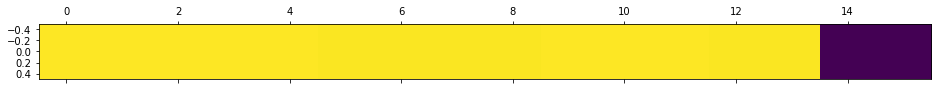

In [83]:
plt.matshow(at2[1].detach().cpu().numpy())

In [76]:
# loss 구할때 

tensor([[0.0716, 0.0716, 0.0716, 0.0715, 0.0714, 0.0712, 0.0712, 0.0713, 0.0713,
         0.0714, 0.0715, 0.0716, 0.0715, 0.0714, 0.0000, 0.0000],
        [0.0716, 0.0716, 0.0716, 0.0715, 0.0714, 0.0712, 0.0712, 0.0713, 0.0713,
         0.0714, 0.0715, 0.0716, 0.0715, 0.0714, 0.0000, 0.0000],
        [0.0715, 0.0715, 0.0716, 0.0715, 0.0714, 0.0712, 0.0712, 0.0713, 0.0713,
         0.0714, 0.0715, 0.0716, 0.0715, 0.0715, 0.0000, 0.0000],
        [0.0715, 0.0715, 0.0715, 0.0714, 0.0714, 0.0713, 0.0712, 0.0713, 0.0713,
         0.0714, 0.0715, 0.0716, 0.0715, 0.0715, 0.0000, 0.0000],
        [0.0715, 0.0715, 0.0715, 0.0714, 0.0714, 0.0712, 0.0712, 0.0713, 0.0713,
         0.0714, 0.0715, 0.0716, 0.0715, 0.0715, 0.0000, 0.0000],
        [0.0715, 0.0715, 0.0715, 0.0714, 0.0714, 0.0713, 0.0712, 0.0714, 0.0713,
         0.0714, 0.0715, 0.0716, 0.0715, 0.0715, 0.0000, 0.0000],
        [0.0715, 0.0715, 0.0715, 0.0714, 0.0714, 0.0712, 0.0712, 0.0714, 0.0713,
         0.0714, 0.0715, 0.0716, 0.07

In [65]:
decoder_outputs = model.model_decoder(
    question_padded, 
    db_padded, 
    col_padded, 
    question_lengths, 
    col_lengths, 
    None, 
    gold
)

In [66]:
for k, v in decoder_outputs.items():
    if k != "wv":
        print(k, v.size())
    else:
        print(k)
        for x in v:
            print(x.size())

sc torch.Size([5, 14])
sa torch.Size([5, 6])
wn torch.Size([5, 5])
wc torch.Size([5, 14])
wo torch.Size([5, 4, 4])
wv
torch.Size([5, 5, 8005])
torch.Size([5, 5, 8005])
torch.Size([5, 1, 8005])
torch.Size([5, 1, 8005])


---

## Testing: Execution-guided beam decoding

In [47]:
beam_size = 4

### SELECT beam search

In [136]:
select_outputs, _ = model_decoder.select_decoder(question_padded, header_padded, col_padded, question_lengths, col_lengths)
select_outputs.size()

torch.Size([2, 20])

construct all possible select + (agg) score

In [137]:
batch_size, n_col = select_output.size()

select_prob = torch.softmax(select_output, 1)  # prob_sc
if n_col < beam_size:
    beam_size_max_col = n_col
else:
    beam_size_max_col = beam_size

prob_sc_sa = torch.zeros([batch_size, beam_size_max_col, n_agg_ops])
prob_sca = torch.zeros_like(prob_sc_sa)
print(prob_sca.size())  # (B, beam-size, n_agg_ops)

torch.Size([2, 4, 6])


In [138]:
# beamseacrh
_, pr_sc_beam = select_outputs.topk(k=beam_size_max_col) # pr_sc_beam: (B, beam_size)
print(f"sc top k: {pr_sc_beam.tolist()}")

for i_beam in range(beam_size_max_col):
    select_idxes = pr_sc_beam[:, i_beam].tolist()  # select one of predicted index
    agg_outputs, _ = model_decoder.agg_decoder(question_padded, header_padded, col_padded, question_lengths, col_lengths, select_idxes)
    agg_prob = torch.softmax(agg_outputs, dim=-1)  # prob_sa: (B, n_agg_ops)
    prob_sc_sa[:, i_beam, :] = agg_prob
    
    prob_sc_selected = select_prob[range(batch_size), select_idx]  # (B,)
    prob_sca[:, i_beam, :] = (agg_prob.t() * prob_sc_selected).t()  # (n_agg_ops, B) \odot (1, B) (broadcast) -> (B, max_col)

sc top k: [[14, 5, 2, 4], [2, 18, 0, 19]]


In [139]:
prob_sc_selected

tensor([0.0503, 0.0503], grad_fn=<IndexBackward>)

In [140]:
print(prob_sc_sa.data)

tensor([[[0.1524, 0.1822, 0.1478, 0.1937, 0.1536, 0.1703],
         [0.1514, 0.1820, 0.1485, 0.1943, 0.1518, 0.1720],
         [0.1518, 0.1816, 0.1489, 0.1934, 0.1524, 0.1720],
         [0.1512, 0.1826, 0.1473, 0.1951, 0.1527, 0.1711]],

        [[0.1536, 0.1789, 0.1471, 0.1923, 0.1539, 0.1742],
         [0.1520, 0.1789, 0.1463, 0.1936, 0.1533, 0.1758],
         [0.1519, 0.1782, 0.1498, 0.1938, 0.1528, 0.1734],
         [0.1532, 0.1790, 0.1466, 0.1933, 0.1541, 0.1738]]])


In [141]:
print(prob_sca.size())  # (B, beam_size, prob_sc * prob_agg)
print(prob_sca.data)

torch.Size([2, 4, 6])
tensor([[[0.0077, 0.0092, 0.0074, 0.0097, 0.0077, 0.0086],
         [0.0076, 0.0092, 0.0075, 0.0098, 0.0076, 0.0087],
         [0.0076, 0.0091, 0.0075, 0.0097, 0.0077, 0.0087],
         [0.0076, 0.0092, 0.0074, 0.0098, 0.0077, 0.0086]],

        [[0.0077, 0.0090, 0.0074, 0.0097, 0.0077, 0.0088],
         [0.0077, 0.0090, 0.0074, 0.0097, 0.0077, 0.0089],
         [0.0076, 0.0090, 0.0075, 0.0098, 0.0077, 0.0087],
         [0.0077, 0.0090, 0.0074, 0.0097, 0.0078, 0.0087]]])


In [142]:
def topk_multi_dim(tensor, n_topk):
    batch_size = tensor.size(0)
    values_1d, idxes_1d = tensor.view(batch_size, -1).topk(n_topk)
    idxes = np.stack(np.unravel_index(idxes_1d, tensor.size()[1:])).transpose(1, 2, 0)
    values = tensor.view(batch_size, -1).gather(1, idxes_1d).numpy()
    return idxes, values

In [143]:
# First flatten to 1-d
if np.prod(prob_sca.shape[1:]) < beam_size:
    beam_size_sca = np.prod(prob_sca.shape[1:])
else:
    beam_size_sca = beam_size
# Now as sc_idx is already sorted, re-map them properly.
# idxes: [sc_beam_idx, sa_idx] -> sca_idxes: [sc_idx, sa_idx]
idxes, values = topk_multi_dim(prob_sca.detach().cpu(), n_topk=beam_size_sca)
sc_beam_idxes = idxes[:, :, 0]
sc_idxes = np.stack([pr_sc_beam.numpy()[i, sc_beam_idx] for i, sc_beam_idx in enumerate(sc_beam_idxes)]) # (B, beam_size)
sca_idxes = np.stack([sc_idxes, idxes[:, :, 1]]).transpose(1, 2, 0)  # (B, beam_size, sc+sa=2)

In [144]:
sca_idxes

array([[[ 4,  3],
        [ 5,  3],
        [14,  3],
        [ 2,  3]],

       [[ 0,  3],
        [18,  3],
        [19,  3],
        [ 2,  3]]])

In [145]:
def check_sc_sa_pairs(tb, pr_sc, pr_sa):
    """
    tb = single table json
    Check whether pr_sc, pr_sa are allowed pairs or not.
    agg_ops = ['', 'MAX', 'MIN', 'COUNT', 'SUM', 'AVG']
    """
    batch_size = len(pr_sc)
    check = [False] * batch_size
    
    for b, b_pr_sc in enumerate(pr_sc):
        if len(tb['types']) <= b_pr_sc:
            check[b] = False
            continue
        b_pr_sa = pr_sa[b]
        header_types = tb['types']
        header_type_sc = header_types[b_pr_sc].lower()
        if header_type_sc == 'text':
            if b_pr_sa == 0 or b_pr_sa == 3: 
                check[b] = True
            else:
                check[b] = False

        elif header_type_sc == 'integer' or header_type_sc == 'float':
            check[b] = True
        else:
            raise Exception("New TYPE!!")

    return check

In [146]:
# Calculate prob_sca, a joint probability
beam_idx_sca = [0] * batch_size
beam_meet_the_final = [False] * batch_size

In [147]:
while True:
    pr_sc = sca_idxes[range(batch_size), beam_idx_sca, 0]
    pr_sa = sca_idxes[range(batch_size), beam_idx_sca, 1]
    check = check_sc_sa_pairs(table["receipts"], pr_sc, pr_sa)
    if sum(check) == batch_size:
        break
    else:
        for b, b_check in enumerate(check):
            if not b_check: # wrong pair
                beam_idx_sca[b] += 1
                if beam_idx_sca[b] >= beam_size_sca:
                    beam_meet_the_final[b] = True
                    beam_idx_sca[b] -= 1
            else:
                beam_meet_the_final[b] = True

    if sum(beam_meet_the_final) == batch_size:
        break

In [148]:
pr_sc_best = list(pr_sc)
pr_sa_best = list(pr_sa)

## WHERE clause beam search

In [149]:
where_num_outputs, _  = model_decoder.where_num_decoder(question_padded, header_padded, col_padded, question_lengths, col_lengths)
prob_wn = torch.softmax(where_num_outputs, dim=-1).detach().cpu().numpy()

In [150]:
prob_wn

array([[0.19943994, 0.21269168, 0.19114491, 0.21635418, 0.18036927],
       [0.1970151 , 0.21438198, 0.19467372, 0.21400847, 0.17992072]],
      dtype=float32)

In [151]:
where_col_outputs, _ = model_decoder.where_col_decoder(question_padded, header_padded, col_padded, question_lengths, col_lengths)
where_nums = model_decoder.predict_decoder("wn", where_num_outputs=where_num_outputs)
prob_wc = torch.sigmoid(where_col_outputs).detach().cpu().numpy()

In [152]:
prob_wc

array([[0.49202684, 0.4923531 , 0.49339655, 0.4926352 , 0.4921672 ,
        0.49323654, 0.4927438 , 0.4918207 , 0.4921981 , 0.49224687,
        0.49229336, 0.49169996, 0.48907605, 0.4890667 , 0.48958477,
        0.4892638 , 0.48943475, 0.4897049 , 0.4910051 , 0.49259278],
       [0.4946221 , 0.49537787, 0.49438062, 0.49485302, 0.4945096 ,
        0.49569654, 0.49484485, 0.49506623, 0.4936429 , 0.49399838,
        0.49496365, 0.4929868 , 0.49419218, 0.49251673, 0.49326468,
        0.4935392 , 0.4941137 , 0.4930429 , 0.49313435, 0.4940745 ]],
      dtype=float32)

In [157]:
pr_wn_max = [max_where_conds]*batch_size
where_col_idxes = model_decoder.predict_decoder("wc", where_col_outputs=where_col_outputs, where_nums=where_nums)

In [167]:
prob_wc[b, b_where_col_idxes]

array([0.4890667 , 0.48907605, 0.4892638 ], dtype=float32)

In [168]:
prob_wc_max = np.zeros([batch_size, max_where_conds])
for b, b_where_col_idxes in enumerate(where_col_idxes):
    prob_wc_max[b, :] = list(prob_wc[b, b_where_col_idxes]) + [0.0]*(max_where_conds - len(b_where_col_idxes))

In [171]:
where_op_outputs = model_decoder.where_op_decoder(question_padded, header_padded, col_padded, question_lengths, where_nums, where_col_idxes)
where_op_idxes = model_decoder.predict_decoder("wo", where_op_outputs=where_op_outputs, where_nums=where_nums)
prob_wo = torch.softmax(where_op_outputs, dim=-1).detach().cpu().numpy()  # (B, max_where_num, )

writing ...

In [161]:
prob_wc[0, [13, 12, 15]]

array([0.4890667 , 0.48907605, 0.4892638 ], dtype=float32)

In [ ]:
# First flatten to 1-d
if np.prod(prob_sca.shape[1:]) < beam_size:
    beam_size_sca = np.prod(prob_sca.shape[1:])
else:
    beam_size_sca = beam_size
idxs_s, values_s = topk_multi_dim(torch.tensor(prob_sca), n_topk=beam_size_sca, batch_exist=True)
# Now as sc_idx is already sorted, re-map them properly.

idxs_s = remap_sc_idx(idxs_s, pr_sc_beam) # [sc_beam_idx, sa_idx] -> [sc_idx, sa_idx]
idxs_arr = array(idxs_s)
# [B, beam_size, remainig dim]
# idxs[b][0] gives first probable [sc_idx, sa_idx] pairs.
# idxs[b][1] gives of second.

# Calculate prob_sca, a joint probability
beam_idx_sca = [0] * bS
beam_meet_the_final = [False] * bS
while True:
    pr_sc = idxs_arr[range(bS),beam_idx_sca,0]
    pr_sa = idxs_arr[range(bS),beam_idx_sca,1]

    # map index properly

    check = check_sc_sa_pairs(tb, pr_sc, pr_sa)

    if sum(check) == bS:
        break
    else:
        for b, check1 in enumerate(check):
            if not check1: # wrong pair
                beam_idx_sca[b] += 1
                if beam_idx_sca[b] >= beam_size_sca:
                    beam_meet_the_final[b] = True
                    beam_idx_sca[b] -= 1
            else:
                beam_meet_the_final[b] = True

    if sum(beam_meet_the_final) == bS:
        break